###### In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly
interested in recognising whether two given faces are of the same person or not. Below are the steps involved in the project.
- Load the dataset and create the metadata.
- Check some samples of metadata.
- Load the pre-trained model and weights.
- Generate Embedding vectors for each face in the dataset.
- Build distance metrics for identifying the distance between two given images.
- Use PCA for dimensionality reduction.
- Build an SVM classifier to map each image to its right person.
- Predict using the SVM model.

###### Importing libraries

In [8]:
import tensorflow
tensorflow.__version__

'2.1.0'

In [9]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
   

from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout
from PIL import Image


Using TensorFlow backend.


tensorflow.keras.backend.image_data_format()

In [3]:
#channels_first
#tensorflow.keras.backend.set_image_data_format('channels_last')

In [4]:
os.listdir()

['.ipynb_checkpoints',
 'Aaron Paul0_262.jpg',
 'Aaron Paul55_274.jpg',
 'Alvaro Morte2_863.jpg',
 'amber heard face3.jpg',
 'Part 3 - vgg_face_weights.h5',
 'Part3_v0.ipynb',
 'PINS',
 'PINS_alt']

###### Setting data path and extracting details on images and folders

In [79]:
path='PINS/'
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [6]:
dir_list

['pins_Aaron Paul',
 'pins_Alvaro Morte',
 'pins_Amanda Crew',
 'pins_Amaury Nolasco',
 'pins_Anna Gunn',
 'pins_Benedict Cumberbatch',
 'pins_Betsy Brandt',
 'pins_Brenton Thwaites',
 'pins_Brit Marling',
 'pins_Bryan Cranston',
 'pins_Caity Lotz',
 'pins_Cameron Monaghan',
 'pins_Chance Perdomo',
 'pins_Chris Evans',
 'pins_Chris Pratt',
 'pins_Cobie Smulders',
 'pins_Danielle Panabaker',
 'pins_Dave Franco',
 'pins_Dominic Purcell',
 'pins_Dwayne Johnson',
 'pins_Emilia Clarke',
 'pins_Emily Bett Rickards',
 'pins_Emma Stone',
 'pins_Gwyneth Paltrow',
 'pins_Henry Cavil',
 'pins_Jason Momoa',
 'pins_Jeremy Renner',
 'pins_Jesse Eisenberg',
 'pins_Jim Parsons',
 'pins_Jon Bernthal',
 'pins_Josh Radnor',
 'pins_Kit Harington',
 'pins_Krysten Ritter',
 'pins_Kumail Nanjiani',
 'pins_Maisie Williams',
 'pins_Mark Ruffalo',
 'pins_Martin Starr',
 'pins_Melissa benoit',
 'pins_Mike Colter',
 'pins_Morena Baccarin',
 'pins_Morgan Freeman',
 'pins_Natalie Portman',
 'pins_Neil Patrick Harri

In [7]:
import h5py

In [8]:
rawData=h5py.File('Part 3 - vgg_face_weights.h5','r')

- Model weight details

In [9]:
list(rawData.keys())

['activation_2',
 'conv1_1',
 'conv1_2',
 'conv2_1',
 'conv2_2',
 'conv3_1',
 'conv3_2',
 'conv3_3',
 'conv4_1',
 'conv4_2',
 'conv4_3',
 'conv5_1',
 'conv5_2',
 'conv5_3',
 'dropout_3',
 'dropout_4',
 'fc6',
 'fc7',
 'fc8',
 'flatten_2',
 'input_4',
 'max_pooling2d_10',
 'max_pooling2d_11',
 'max_pooling2d_12',
 'max_pooling2d_8',
 'max_pooling2d_9',
 'zero_padding2d_18',
 'zero_padding2d_19',
 'zero_padding2d_20',
 'zero_padding2d_21',
 'zero_padding2d_22',
 'zero_padding2d_23',
 'zero_padding2d_24',
 'zero_padding2d_25',
 'zero_padding2d_26',
 'zero_padding2d_27',
 'zero_padding2d_28',
 'zero_padding2d_29',
 'zero_padding2d_30']

In [10]:
from keras.models import load_model

In [11]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

###### Evaluating images in the folders

Image has a shao of (301, 299, 3)
The number of features in image from the data set are: 269997


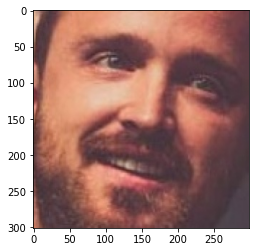

In [12]:

img = cv2.imread('PINS/pins_Aaron Paul/Aaron Paul0_262.jpg',cv2.IMREAD_COLOR)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print("Image has a shao of {0}".format(img.shape))
flattened_img = img.flatten()
print("The number of features in image from the data set are: {0}".format(flattened_img.shape[0]))
plt.imshow(img)

Image shape of (299, 299, 3)
The number of features in any image from the data set are: 268203


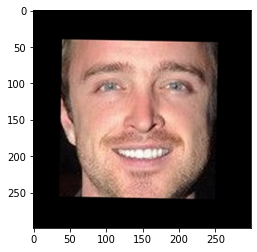

In [13]:


img = cv2.imread('PINS/pins_Aaron Paul/Aaron Paul53_266.jpg',cv2.IMREAD_COLOR)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print("Image shape of {0}".format(img.shape))
flattened_img = img.flatten()
print("The number of features in any image from the data set are: {0}".format(flattened_img.shape[0]))
plt.imshow(img)

In [54]:
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

In [55]:
pinPath='PINS/'
cat_Folder_list=get_immediate_subdirectories(pinPath)

In [16]:
print('List of Pins: ', cat_Folder_list)

List of Pins:  ['pins_Aaron Paul', 'pins_alexandra daddario', 'pins_Alvaro Morte', 'pins_alycia debnam carey face', 'pins_Amanda Crew', 'pins_Amaury Nolasco', 'pins_amber heard face', 'pins_Anna Gunn', 'pins_anne hathaway', 'pins_barbara palvin face', 'pins_bellamy blake face', 'pins_Benedict Cumberbatch', 'pins_Betsy Brandt', 'pins_bill gates', 'pins_Brenton Thwaites', 'pins_brie larson', 'pins_Brit Marling', 'pins_Bryan Cranston', 'pins_Caity Lotz', 'pins_Cameron Monaghan', 'pins_chadwick boseman face', 'pins_Chance Perdomo', 'pins_Chris Evans', 'pins_Chris Pratt', 'pins_Cobie Smulders', 'pins_Danielle Panabaker', 'pins_Dave Franco', 'pins_david mazouz', 'pins_Dominic Purcell', 'pins_drake', 'pins_dua lipa face', 'pins_Dwayne Johnson', 'pins_eliza taylor', 'pins_elizabeth olsen face', 'pins_elon musk', 'pins_Emilia Clarke', 'pins_Emily Bett Rickards', 'pins_Emma Stone', 'pins_emma watson face', 'pins_gal gadot face', 'pins_grant gustin face', 'pins_Gwyneth Paltrow', 'pins_Henry Cavil

In [17]:

for img in cat_Folder_list:
    print('{}   -->   {} training images'.format(img, len(os.listdir(os.path.join(pinPath, img)))))

pins_Aaron Paul   -->   86 training images
pins_alexandra daddario   -->   165 training images
pins_Alvaro Morte   -->   91 training images
pins_alycia debnam carey face   -->   144 training images
pins_Amanda Crew   -->   118 training images
pins_Amaury Nolasco   -->   113 training images
pins_amber heard face   -->   151 training images
pins_Anna Gunn   -->   66 training images
pins_anne hathaway   -->   151 training images
pins_barbara palvin face   -->   142 training images
pins_bellamy blake face   -->   89 training images
pins_Benedict Cumberbatch   -->   81 training images
pins_Betsy Brandt   -->   68 training images
pins_bill gates   -->   86 training images
pins_Brenton Thwaites   -->   130 training images
pins_brie larson   -->   128 training images
pins_Brit Marling   -->   122 training images
pins_Bryan Cranston   -->   80 training images
pins_Caity Lotz   -->   123 training images
pins_Cameron Monaghan   -->   112 training images
pins_chadwick boseman face   -->   119 trai

- We have 10,777 images spread across 100 folders
- Image size is varying with 3 channels

- Attempting to import all image 

In [205]:
imgsize=224

from pathlib import Path
from skimage.io import imread
from keras.preprocessing import image
import cv2 as cv
def load_image_files(container_path):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    images = []
    flat_data = []
    target = []
    count = 0
    train_img = []
    label_img = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            img = imread(file)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_pred = cv.resize(img, (imgsize, imgsize), interpolation=cv.INTER_AREA)
            img_pred = image.img_to_array(img_pred)
            img_pred = img_pred / 255.0
            train_img.append(img_pred)
            label_img.append(categories[i])
            
    X = np.array(train_img)
    y = np.array(label_img)
    return X,y

- Not able to import image due to size issues

In [206]:

X = []
y = []
#X,y = load_image_files(pinPath)

In [66]:
# not able to use 224 x 224 img due to system limitations so 
# spliting it for processing image just before usage
# only keeping the path names to get imported just before processing 
imgsize=224

from pathlib import Path
from skimage.io import imread
from keras.preprocessing import image
import cv2 as cv
def load_image_files(container_path):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    images = []
    flat_data = []
    target = []
    count = 0
    train_img = []
    label_img = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            #count += 1
            #img = imread(file)
            #img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            #img_pred = cv.resize(img, (imgsize, imgsize), interpolation=cv.INTER_AREA)
            #img_pred = image.img_to_array(img_pred)
            #img_pred = img_pred / 255.0
            #train_img.append(img_pred)
            label_img.append(categories[i])
            train_img.append(file)
            #print(file)
    X = np.array(train_img)
    y = np.array(label_img)
    return X,y

In [67]:

X = []
y = []
X,y = load_image_files(pinPath)

In [102]:
#func for processing image path to image
def prepImg(path):
    img = imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_pred = cv.resize(img, (imgsize, imgsize), interpolation=cv.INTER_AREA)
    img_pred = image.img_to_array(img_pred)
    img_pred = img_pred / 255.0
    return img_pred

##### Exploring shape of imported data

In [24]:
X.shape

(10770,)

In [25]:
y.shape

(10770,)

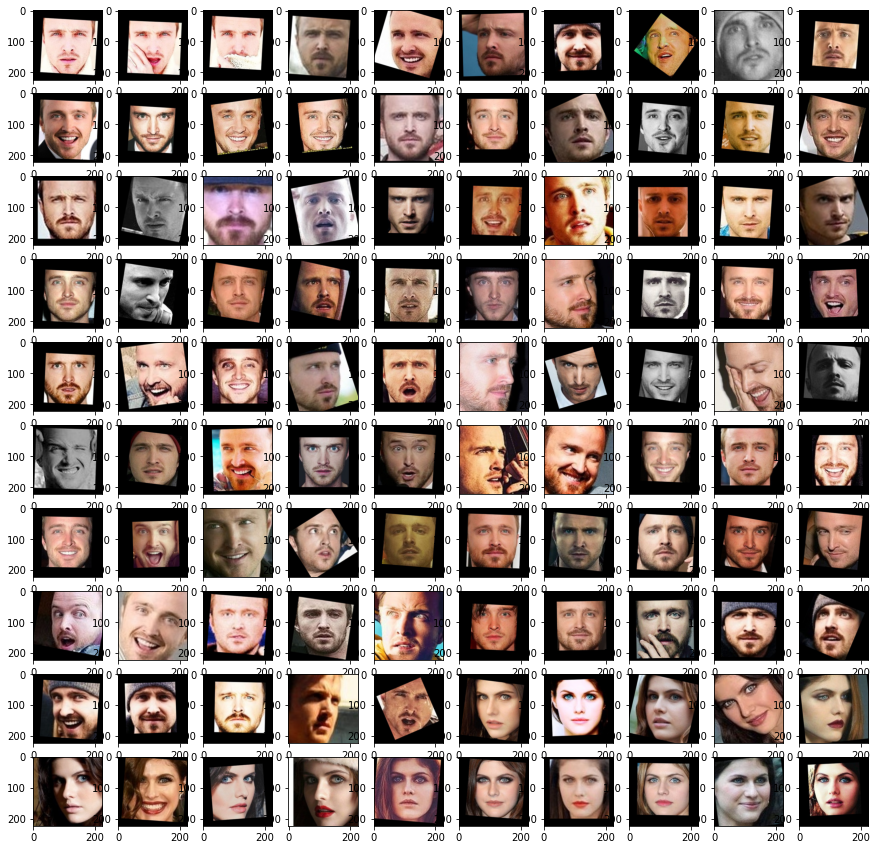

Label:  ['pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul'
 'pins_Aaron Paul' 'pins_Aaron Paul' 'pins_

In [26]:
fig=plt.figure(figsize=(15,15))

for i in range(1,101):
  img=X[i]
  img_pred=prepImg(img)
  fig.add_subplot(10,10,i)
  img_pred=cv.cvtColor(img_pred,cv.COLOR_BGR2RGB)
  plt.imshow(img_pred)

plt.show()
print('Label: ', y[1:101])

In [27]:
tempData = np.array(y)
print(np.unique(tempData))
print(len(np.unique(tempData)))
classes=tempData

['pins_Aaron Paul' 'pins_Alvaro Morte' 'pins_Amanda Crew'
 'pins_Amaury Nolasco' 'pins_Anna Gunn' 'pins_Benedict Cumberbatch'
 'pins_Betsy Brandt' 'pins_Brenton Thwaites' 'pins_Brit Marling'
 'pins_Bryan Cranston' 'pins_Caity Lotz' 'pins_Cameron Monaghan'
 'pins_Chance Perdomo' 'pins_Chris Evans' 'pins_Chris Pratt'
 'pins_Cobie Smulders' 'pins_Danielle Panabaker' 'pins_Dave Franco'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Emilia Clarke'
 'pins_Emily Bett Rickards' 'pins_Emma Stone' 'pins_Gwyneth Paltrow'
 'pins_Henry Cavil' 'pins_Jason Momoa' 'pins_Jeremy Renner'
 'pins_Jesse Eisenberg' 'pins_Jim Parsons' 'pins_Jon Bernthal'
 'pins_Josh Radnor' 'pins_Kit Harington' 'pins_Krysten Ritter'
 'pins_Kumail Nanjiani' 'pins_Maisie Williams' 'pins_Mark Ruffalo'
 'pins_Martin Starr' 'pins_Melissa benoit' 'pins_Mike Colter'
 'pins_Morena Baccarin' 'pins_Morgan Freeman' 'pins_Natalie Portman'
 'pins_Neil Patrick Harris' 'pins_Paul Rudd' 'pins_Pedro Alonso'
 'pins_Peter Dinklage' 'pins_R

- total 100 folders

In [28]:
from sklearn.preprocessing import LabelBinarizer

def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

In [29]:
labels = generate_one_hot_encoding(classes)
print(labels)
len(labels)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


10770

### Let's define our model now

In [30]:
# Most Recent One (Suggested)
#!pip install git+https://github.com/rcmalli/keras-vggface.git
# Release Version
#!pip install keras_vggface

In [31]:
from keras_vggface.vggface import VGGFace

# Based on VGG16 architecture -> old paper(2015)
#vggface = VGGFace(model='vgg16') # or VGGFace() as default

# Based on RESNET50 architecture -> new paper(2017)
#vggface = VGGFace(model='resnet50')

# Based on SENET50 architecture -> new paper(2017)
#vggface = VGGFace(model='senet50')

In [32]:
#getting mismatch exception while importing model from VGGFace and loading the weights
#setting up the model locally
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [33]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

- Model weights are loaded

In [34]:
from keras.models import model_from_json
model.load_weights('Part 3 - vgg_face_weights.h5')

In [35]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [36]:
#for using single image 
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [37]:
#References
#https://towardsdatascience.com/cosine-similarity-how-does-it-measure-the-similarity-maths-behind-and-usage-in-python-50ad30aad7db
#https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
#https://www.geeksforgeeks.org/calculate-the-euclidean-distance-using-numpy/

def findCosineSimilarity(img1, img2):
    a = np.matmul(np.transpose(img1), img2)
    b = np.sum(np.multiply(img1, img1))
    c = np.sum(np.multiply(img2, img2))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(img1, img2):
    '''Compute Euclidean Distance between two vectors'''
    euclidean_distance = img1 - img2
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [66]:
threshold = 0.30
#
def verifyFace(img1, img2):
    img1_representation = vgg_face_descriptor.predict(preprocess_image('%s' % (img1)))[0,:]
    img2_representation = vgg_face_descriptor.predict(preprocess_image('%s' % (img2)))[0,:]
    
    print(img1_representation)
    print(img2_representation)
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Cosine similarity: ",cosine_similarity)
    print("Euclidean distance: ",euclidean_distance)
    
    if(cosine_similarity < threshold):
        print("Cosine Similarity is Less ----> these faces are similar.")
    else:
        print("Cosine Similarity is High ----> these faces are notsimilar.")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img('%s' % (img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img('%s' % (img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

### Validating the model efficiency

[ 2.424132  -0.7524346  1.7479202 ...  0.6944292  1.2702495  2.5595434]
[ 0.4215855   1.0482198  -1.6095939  ... -1.6810613  -0.55425453
  3.1133552 ]
Cosine similarity:  0.5912998020648956
Euclidean distance:  150.59187
Cosine Similarity is High ----> these faces are notsimilar.


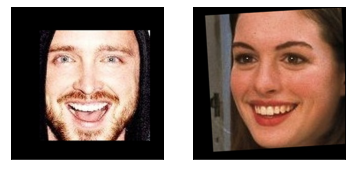

-----------------------------------------


In [67]:
verifyFace(X[60], X[1000])

[ 2.8089395  -0.86702013 -0.32088467 ...  0.5957145  -0.14407189
  0.35859078]
[ 6.253914    0.6396156  -0.39178923 ...  2.5673013   0.0621729
  1.8216649 ]
Cosine similarity:  0.21683800220489502
Euclidean distance:  77.96491
Cosine Similarity is Less ----> these faces are similar.


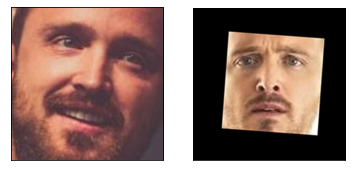

-----------------------------------------


In [68]:
verifyFace(X[0], X[10])

[ 6.253914    0.6396156  -0.39178923 ...  2.5673013   0.0621729
  1.8216649 ]
[ 0.6582836 -1.7917728 -2.228295  ... -0.4504205 -0.9703641 -0.9037784]
Cosine similarity:  0.390178382396698
Euclidean distance:  100.624344
Cosine Similarity is High ----> these faces are notsimilar.


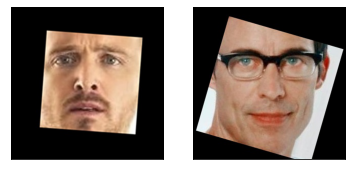

-----------------------------------------


In [69]:
verifyFace(X[10], X[10000])

[ 2.8089395  -0.86702013 -0.32088467 ...  0.5957145  -0.14407189
  0.35859078]
[ 1.3709652  2.1157436  3.592179  ... -3.1052194  1.8143219  1.300169 ]
Cosine similarity:  0.5170458853244781
Euclidean distance:  110.38923
Cosine Similarity is High ----> these faces are notsimilar.


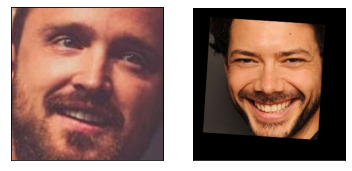

-----------------------------------------


In [70]:
verifyFace("F:/GreatLearning/AI/ComputerVision/Project2/Part3/Aaron Paul0_262.jpg", "F:/GreatLearning/AI/ComputerVision/Project2/Part3/Alvaro Morte2_863.jpg")

[ 2.8089395  -0.86702013 -0.32088467 ...  0.5957145  -0.14407189
  0.35859078]
[ 9.014037   -1.299652   -0.77589285 ...  2.1394198  -0.8850122
  1.9243371 ]
Cosine similarity:  0.23873239755630493
Euclidean distance:  77.322495
Cosine Similarity is Less ----> these faces are similar.


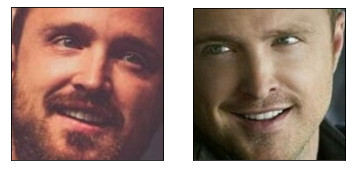

-----------------------------------------


In [71]:
verifyFace("F:/GreatLearning/AI/ComputerVision/Project2/Part3/Aaron Paul0_262.jpg", "F:/GreatLearning/AI/ComputerVision/Project2/Part3/Aaron Paul55_274.jpg")

[ 0.4215855   1.0482198  -1.6095939  ... -1.6810613  -0.55425453
  3.1133552 ]
[ 0.4215855   1.0482198  -1.6095939  ... -1.6810613  -0.55425453
  3.1133552 ]
Cosine similarity:  0.0
Euclidean distance:  0.0
Cosine Similarity is Less ----> these faces are similar.


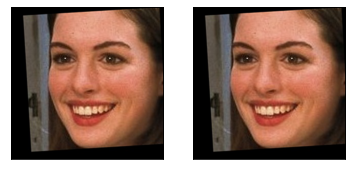

-----------------------------------------


In [91]:
verifyFace(X[1000], X[1000])

- We can observe the model is working efficinetly and able to identify which faces are similar and which are different
- we have kept the cosine similarity at 0.3
- we will be using the pre trained model for getting embedding details, identifying euclidean distances, PCA to reduce dimensionnality and images similarity using SVM

#### Getting Embedding

- You pass your images through a CNN (the encoder) with decreasing layer size. The last layer of this network is the one that produce the embeddings (that is, a lower dimensional representation of your input), and the number of neurons you use here is the length of your vector embedding for the input images.

- Now, your embeddings are useful only if they actual encode the data in your images. To achieve this, you need another network (the decoder) that takes as input the image embedding and outputs an image with the same dimension of the input. Here, you try to minimize a loss function that tells you the distance between the image you generate from the embedding and the initial image (it might be cosine or euclidean distance between pixel values).

- Finally, if you need to output the embedding of an image, you just need to pass the image through the encoder network and collect the output.

In [76]:


def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [77]:
print(vgg_face_descriptor.inputs)
print(vgg_face_descriptor.outputs)

[<tf.Tensor 'zero_padding2d_1_input:0' shape=(None, 224, 224, 3) dtype=float32>]
[<tf.Tensor 'activation_1/Softmax:0' shape=(None, None) dtype=float32>]


In [92]:

# make prediction to get embedding
yhat = vgg_face_descriptor.predict(preprocess_image(X[1]))[0,:]
# get embedding
embedding = get_embedding(vgg_face_descriptor, img_to_array(prepImg(X[10])))



In [93]:
embedding

array([ 0.07845265,  0.0069484 , -0.00807884, ...,  0.02370215,
       -0.00063804,  0.02481364], dtype=float32)

In [94]:

print(findCosineSimilarity(yhat,embedding))

0.17086613178253174


In [95]:
print(findEuclideanDistance(yhat,embedding))

100.491486


In [111]:
#for whole database it took hours to execute so marking a breakpoint at close to 1000 images only 
# and saving the original dataset separtely. 1k images also took more than a hour to process
face_database = {}
count=0
for img in X:
    #print(img)
    identity = os.path.splitext(os.path.basename(img))[0]
    #print(identity)
    face_database[identity] = get_embedding(vgg_face_descriptor,img_to_array(prepImg(img)))
    count+=1
    if(count>=1000):
        break


#print(face_database)

In [112]:
import pickle
f = open("face_embed_db_1k.pkl","wb")
pickle.dump(face_database,f)
f.close()

In [116]:
face_database.keys()

dict_keys(['Aaron Paul0_262', 'Aaron Paul101_247', 'Aaron Paul101_248', 'Aaron Paul101_249', 'Aaron Paul103_217', 'Aaron Paul113_228', 'Aaron Paul114_271', 'Aaron Paul116_240', 'Aaron Paul117_213', 'Aaron Paul119_219', 'Aaron Paul120_290', 'Aaron Paul124_221', 'Aaron Paul126_291', 'Aaron Paul129_259', 'Aaron Paul129_260', 'Aaron Paul130_215', 'Aaron Paul132_236', 'Aaron Paul136_225', 'Aaron Paul137_250', 'Aaron Paul138_233', 'Aaron Paul140_243', 'Aaron Paul145_256', 'Aaron Paul155_220', 'Aaron Paul156_294', 'Aaron Paul158_277', 'Aaron Paul164_276', 'Aaron Paul165_254', 'Aaron Paul168_268', 'Aaron Paul170_237', 'Aaron Paul172_288', 'Aaron Paul173_292', 'Aaron Paul174_216', 'Aaron Paul178_273', 'Aaron Paul179_283', 'Aaron Paul17_280', 'Aaron Paul180_295', 'Aaron Paul181_244', 'Aaron Paul182_270', 'Aaron Paul184_289', 'Aaron Paul188_255', 'Aaron Paul18_252', 'Aaron Paul190_263', 'Aaron Paul191_269', 'Aaron Paul199_212', 'Aaron Paul21_287', 'Aaron Paul22_265', 'Aaron Paul24_282', 'Aaron Pa

In [209]:
#for whole database it took hours to execute so marking a breakpoint at close to 1000 images only 
# and saving the original dataset separtely. 1k images also took more than a hour to process
face_database2 = []
count=0
for img in X:
    #print(img)
    #identity = os.path.splitext(os.path.basename(img))[0]
    #print(identity)
    face_database2.append(get_embedding(vgg_face_descriptor,img_to_array(prepImg(img))))
    count+=1
    print(img)
    #if(count>=1000):
    #    break


#print(face_database)

PINS\pins_Aaron Paul\Aaron Paul0_262.jpg
PINS\pins_Aaron Paul\Aaron Paul101_247.jpg
PINS\pins_Aaron Paul\Aaron Paul101_248.jpg
PINS\pins_Aaron Paul\Aaron Paul101_249.jpg
PINS\pins_Aaron Paul\Aaron Paul103_217.jpg
PINS\pins_Aaron Paul\Aaron Paul113_228.jpg
PINS\pins_Aaron Paul\Aaron Paul114_271.jpg
PINS\pins_Aaron Paul\Aaron Paul116_240.jpg
PINS\pins_Aaron Paul\Aaron Paul117_213.jpg
PINS\pins_Aaron Paul\Aaron Paul119_219.jpg
PINS\pins_Aaron Paul\Aaron Paul120_290.jpg
PINS\pins_Aaron Paul\Aaron Paul124_221.jpg
PINS\pins_Aaron Paul\Aaron Paul126_291.jpg
PINS\pins_Aaron Paul\Aaron Paul129_259.jpg
PINS\pins_Aaron Paul\Aaron Paul129_260.jpg
PINS\pins_Aaron Paul\Aaron Paul130_215.jpg
PINS\pins_Aaron Paul\Aaron Paul132_236.jpg
PINS\pins_Aaron Paul\Aaron Paul136_225.jpg
PINS\pins_Aaron Paul\Aaron Paul137_250.jpg
PINS\pins_Aaron Paul\Aaron Paul138_233.jpg
PINS\pins_Aaron Paul\Aaron Paul140_243.jpg
PINS\pins_Aaron Paul\Aaron Paul145_256.jpg
PINS\pins_Aaron Paul\Aaron Paul155_220.jpg
PINS\pins_Aar

PINS\pins_alexandra daddario\alexandra daddario23.jpg
PINS\pins_alexandra daddario\alexandra daddario24.jpg
PINS\pins_alexandra daddario\alexandra daddario25.jpg
PINS\pins_alexandra daddario\alexandra daddario26.jpg
PINS\pins_alexandra daddario\alexandra daddario27.jpg
PINS\pins_alexandra daddario\alexandra daddario28.jpg
PINS\pins_alexandra daddario\alexandra daddario3.jpg
PINS\pins_alexandra daddario\alexandra daddario30.jpg
PINS\pins_alexandra daddario\alexandra daddario31.jpg
PINS\pins_alexandra daddario\alexandra daddario32.jpg
PINS\pins_alexandra daddario\alexandra daddario33.jpg
PINS\pins_alexandra daddario\alexandra daddario34.jpg
PINS\pins_alexandra daddario\alexandra daddario35.jpg
PINS\pins_alexandra daddario\alexandra daddario36.jpg
PINS\pins_alexandra daddario\alexandra daddario37.jpg
PINS\pins_alexandra daddario\alexandra daddario38.jpg
PINS\pins_alexandra daddario\alexandra daddario39.jpg
PINS\pins_alexandra daddario\alexandra daddario4.jpg
PINS\pins_alexandra daddario\a

PINS\pins_Alvaro Morte\Alvaro Morte85_835.jpg
PINS\pins_Alvaro Morte\Alvaro Morte88_822.jpg
PINS\pins_Alvaro Morte\Alvaro Morte8_831.jpg
PINS\pins_Alvaro Morte\Alvaro Morte91_833.jpg
PINS\pins_Alvaro Morte\Alvaro Morte92_846.jpg
PINS\pins_Alvaro Morte\Alvaro Morte93_865.jpg
PINS\pins_Alvaro Morte\Alvaro Morte95_843.jpg
PINS\pins_Alvaro Morte\Alvaro Morte97_830.jpg
PINS\pins_Alvaro Morte\Alvaro Morte99_877.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face1.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face10.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face100.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face101.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face102.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face103.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face104.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face105.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey

PINS\pins_alycia debnam carey face\alycia debnam carey face75.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face76.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face77.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face78.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face79.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face8.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face80.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face81.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face82.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face83.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face84.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face85.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face86.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face87.jpg
PINS\pins_alycia debnam carey face\alycia debnam carey face88.jpg
PINS\pins_a

PINS\pins_Amaury Nolasco\Amaury Nolasco30.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco31.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco32.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco33.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco34.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco35.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco36.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco37.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco38.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco39.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco4.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco40.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco41.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco42.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco43.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco44.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco45.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco46.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco47.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco48.jpg
PINS\pins_Amaury Nolasco\Amaury Nolasco49.jpg
PINS\pins_Amaury Nolasco\Amaury Nol

PINS\pins_amber heard face\amber heard face49.jpg
PINS\pins_amber heard face\amber heard face5.jpg
PINS\pins_amber heard face\amber heard face50.jpg
PINS\pins_amber heard face\amber heard face51.jpg
PINS\pins_amber heard face\amber heard face52.jpg
PINS\pins_amber heard face\amber heard face53.jpg
PINS\pins_amber heard face\amber heard face54.jpg
PINS\pins_amber heard face\amber heard face55.jpg
PINS\pins_amber heard face\amber heard face56.jpg
PINS\pins_amber heard face\amber heard face57.jpg
PINS\pins_amber heard face\amber heard face58.jpg
PINS\pins_amber heard face\amber heard face59.jpg
PINS\pins_amber heard face\amber heard face6.jpg
PINS\pins_amber heard face\amber heard face60.jpg
PINS\pins_amber heard face\amber heard face61.jpg
PINS\pins_amber heard face\amber heard face62.jpg
PINS\pins_amber heard face\amber heard face63.jpg
PINS\pins_amber heard face\amber heard face64.jpg
PINS\pins_amber heard face\amber heard face65.jpg
PINS\pins_amber heard face\amber heard face66.jpg
PI

PINS\pins_anne hathaway\anne hathaway16.jpg
PINS\pins_anne hathaway\anne hathaway17.jpg
PINS\pins_anne hathaway\anne hathaway18.jpg
PINS\pins_anne hathaway\anne hathaway19.jpg
PINS\pins_anne hathaway\anne hathaway2.jpg
PINS\pins_anne hathaway\anne hathaway20.jpg
PINS\pins_anne hathaway\anne hathaway21.jpg
PINS\pins_anne hathaway\anne hathaway22.jpg
PINS\pins_anne hathaway\anne hathaway23.jpg
PINS\pins_anne hathaway\anne hathaway24.jpg
PINS\pins_anne hathaway\anne hathaway25.jpg
PINS\pins_anne hathaway\anne hathaway26.jpg
PINS\pins_anne hathaway\anne hathaway27.jpg
PINS\pins_anne hathaway\anne hathaway28.jpg
PINS\pins_anne hathaway\anne hathaway29.jpg
PINS\pins_anne hathaway\anne hathaway3.jpg
PINS\pins_anne hathaway\anne hathaway30.jpg
PINS\pins_anne hathaway\anne hathaway31.jpg
PINS\pins_anne hathaway\anne hathaway32.jpg
PINS\pins_anne hathaway\anne hathaway33.jpg
PINS\pins_anne hathaway\anne hathaway34.jpg
PINS\pins_anne hathaway\anne hathaway35.jpg
PINS\pins_anne hathaway\anne hatha

PINS\pins_barbara palvin face\barbara palvin face39.jpg
PINS\pins_barbara palvin face\barbara palvin face4.jpg
PINS\pins_barbara palvin face\barbara palvin face40.jpg
PINS\pins_barbara palvin face\barbara palvin face41.jpg
PINS\pins_barbara palvin face\barbara palvin face42.jpg
PINS\pins_barbara palvin face\barbara palvin face43.jpg
PINS\pins_barbara palvin face\barbara palvin face44.jpg
PINS\pins_barbara palvin face\barbara palvin face45.jpg
PINS\pins_barbara palvin face\barbara palvin face46.jpg
PINS\pins_barbara palvin face\barbara palvin face47.jpg
PINS\pins_barbara palvin face\barbara palvin face48.jpg
PINS\pins_barbara palvin face\barbara palvin face49.jpg
PINS\pins_barbara palvin face\barbara palvin face5.jpg
PINS\pins_barbara palvin face\barbara palvin face50.jpg
PINS\pins_barbara palvin face\barbara palvin face51.jpg
PINS\pins_barbara palvin face\barbara palvin face52.jpg
PINS\pins_barbara palvin face\barbara palvin face53.jpg
PINS\pins_barbara palvin face\barbara palvin face5

PINS\pins_bellamy blake face\bellamy blake face85.jpg
PINS\pins_bellamy blake face\bellamy blake face86.jpg
PINS\pins_bellamy blake face\bellamy blake face87.jpg
PINS\pins_bellamy blake face\bellamy blake face89.jpg
PINS\pins_bellamy blake face\bellamy blake face9.jpg
PINS\pins_bellamy blake face\bellamy blake face90.jpg
PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch0.jpg
PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch1.jpg
PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch10.jpg
PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch11.jpg
PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch12.jpg
PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch13.jpg
PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch14.jpg
PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch15.jpg
PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch16.jpg
PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch17.jpg
PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch18.jpg
PINS\pins_Benedict Cumberbatch\Benedict C

PINS\pins_bill gates\bill gates10.jpg
PINS\pins_bill gates\bill gates11.jpg
PINS\pins_bill gates\bill gates12.jpg
PINS\pins_bill gates\bill gates13.jpg
PINS\pins_bill gates\bill gates14.jpg
PINS\pins_bill gates\bill gates15.jpg
PINS\pins_bill gates\bill gates16.jpg
PINS\pins_bill gates\bill gates17.jpg
PINS\pins_bill gates\bill gates18.jpg
PINS\pins_bill gates\bill gates19.jpg
PINS\pins_bill gates\bill gates2.jpg
PINS\pins_bill gates\bill gates20.jpg
PINS\pins_bill gates\bill gates21.jpg
PINS\pins_bill gates\bill gates22.jpg
PINS\pins_bill gates\bill gates23.jpg
PINS\pins_bill gates\bill gates24.jpg
PINS\pins_bill gates\bill gates25.jpg
PINS\pins_bill gates\bill gates26.jpg
PINS\pins_bill gates\bill gates27.jpg
PINS\pins_bill gates\bill gates28.jpg
PINS\pins_bill gates\bill gates29.jpg
PINS\pins_bill gates\bill gates3.jpg
PINS\pins_bill gates\bill gates30.jpg
PINS\pins_bill gates\bill gates31.jpg
PINS\pins_bill gates\bill gates32.jpg
PINS\pins_bill gates\bill gates33.jpg
PINS\pins_bill

PINS\pins_Brenton Thwaites\Brenton Thwaites71.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites72.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites73.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites74.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites75.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites76.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites77.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites78.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites79.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites8.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites80.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites81.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites82.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites83.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites84.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites85.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites86.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites87.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites88.jpg
PINS\pins_Brenton Thwaites\Brenton Thwaites89.jpg
P

PINS\pins_Brit Marling\Brit Marling151_503.jpg
PINS\pins_Brit Marling\Brit Marling152_529.jpg
PINS\pins_Brit Marling\Brit Marling153_449.jpg
PINS\pins_Brit Marling\Brit Marling155_480.jpg
PINS\pins_Brit Marling\Brit Marling157_501.jpg
PINS\pins_Brit Marling\Brit Marling159_553.jpg
PINS\pins_Brit Marling\Brit Marling15_477.jpg
PINS\pins_Brit Marling\Brit Marling163_451.jpg
PINS\pins_Brit Marling\Brit Marling165_550.jpg
PINS\pins_Brit Marling\Brit Marling167_536.jpg
PINS\pins_Brit Marling\Brit Marling169_514.jpg
PINS\pins_Brit Marling\Brit Marling16_551.jpg
PINS\pins_Brit Marling\Brit Marling171_507.jpg
PINS\pins_Brit Marling\Brit Marling173_446.jpg
PINS\pins_Brit Marling\Brit Marling174_567.jpg
PINS\pins_Brit Marling\Brit Marling177_460.jpg
PINS\pins_Brit Marling\Brit Marling179_491.jpg
PINS\pins_Brit Marling\Brit Marling181_556.jpg
PINS\pins_Brit Marling\Brit Marling182_524.jpg
PINS\pins_Brit Marling\Brit Marling183_505.jpg
PINS\pins_Brit Marling\Brit Marling184_500.jpg
PINS\pins_Brit 

PINS\pins_Caity Lotz\Caity Lotz0.jpg
PINS\pins_Caity Lotz\Caity Lotz1.jpg
PINS\pins_Caity Lotz\Caity Lotz10.jpg
PINS\pins_Caity Lotz\Caity Lotz100.jpg
PINS\pins_Caity Lotz\Caity Lotz101.jpg
PINS\pins_Caity Lotz\Caity Lotz102.jpg
PINS\pins_Caity Lotz\Caity Lotz103.jpg
PINS\pins_Caity Lotz\Caity Lotz105.jpg
PINS\pins_Caity Lotz\Caity Lotz106.jpg
PINS\pins_Caity Lotz\Caity Lotz107.jpg
PINS\pins_Caity Lotz\Caity Lotz108.jpg
PINS\pins_Caity Lotz\Caity Lotz109.jpg
PINS\pins_Caity Lotz\Caity Lotz11.jpg
PINS\pins_Caity Lotz\Caity Lotz110.jpg
PINS\pins_Caity Lotz\Caity Lotz111.jpg
PINS\pins_Caity Lotz\Caity Lotz112.jpg
PINS\pins_Caity Lotz\Caity Lotz113.jpg
PINS\pins_Caity Lotz\Caity Lotz114.jpg
PINS\pins_Caity Lotz\Caity Lotz115.jpg
PINS\pins_Caity Lotz\Caity Lotz116.jpg
PINS\pins_Caity Lotz\Caity Lotz117.jpg
PINS\pins_Caity Lotz\Caity Lotz118.jpg
PINS\pins_Caity Lotz\Caity Lotz119.jpg
PINS\pins_Caity Lotz\Caity Lotz12.jpg
PINS\pins_Caity Lotz\Caity Lotz120.jpg
PINS\pins_Caity Lotz\Caity Lotz1

PINS\pins_Cameron Monaghan\Cameron Monaghan60.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan61.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan62.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan64.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan65.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan66.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan67.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan68.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan69.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan7.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan70.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan71.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan72.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan73.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan74.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan75.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan76.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan77.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan78.jpg
PINS\pins_Cameron Monaghan\Cameron Monaghan79.jpg
P

PINS\pins_chadwick boseman face\chadwick boseman face84.jpg
PINS\pins_chadwick boseman face\chadwick boseman face85.jpg
PINS\pins_chadwick boseman face\chadwick boseman face86.jpg
PINS\pins_chadwick boseman face\chadwick boseman face87.jpg
PINS\pins_chadwick boseman face\chadwick boseman face88.jpg
PINS\pins_chadwick boseman face\chadwick boseman face89.jpg
PINS\pins_chadwick boseman face\chadwick boseman face9.jpg
PINS\pins_chadwick boseman face\chadwick boseman face90.jpg
PINS\pins_chadwick boseman face\chadwick boseman face91.jpg
PINS\pins_chadwick boseman face\chadwick boseman face92.jpg
PINS\pins_chadwick boseman face\chadwick boseman face93.jpg
PINS\pins_chadwick boseman face\chadwick boseman face94.jpg
PINS\pins_chadwick boseman face\chadwick boseman face95.jpg
PINS\pins_chadwick boseman face\chadwick boseman face96.jpg
PINS\pins_chadwick boseman face\chadwick boseman face97.jpg
PINS\pins_chadwick boseman face\chadwick boseman face98.jpg
PINS\pins_chadwick boseman face\chadwick 

PINS\pins_Chris Evans\Chris Evans82.jpg
PINS\pins_Chris Evans\Chris Evans83.jpg
PINS\pins_Chris Evans\Chris Evans84.jpg
PINS\pins_Chris Evans\Chris Evans85.jpg
PINS\pins_Chris Evans\Chris Evans86.jpg
PINS\pins_Chris Evans\Chris Evans87.jpg
PINS\pins_Chris Evans\Chris Evans9.jpg
PINS\pins_Chris Pratt\Chris Pratt0.jpg
PINS\pins_Chris Pratt\Chris Pratt1.jpg
PINS\pins_Chris Pratt\Chris Pratt10.jpg
PINS\pins_Chris Pratt\Chris Pratt100.jpg
PINS\pins_Chris Pratt\Chris Pratt101.jpg
PINS\pins_Chris Pratt\Chris Pratt102.jpg
PINS\pins_Chris Pratt\Chris Pratt103.jpg
PINS\pins_Chris Pratt\Chris Pratt104.jpg
PINS\pins_Chris Pratt\Chris Pratt105.jpg
PINS\pins_Chris Pratt\Chris Pratt106.jpg
PINS\pins_Chris Pratt\Chris Pratt107.jpg
PINS\pins_Chris Pratt\Chris Pratt108.jpg
PINS\pins_Chris Pratt\Chris Pratt109.jpg
PINS\pins_Chris Pratt\Chris Pratt11.jpg
PINS\pins_Chris Pratt\Chris Pratt110.jpg
PINS\pins_Chris Pratt\Chris Pratt111.jpg
PINS\pins_Chris Pratt\Chris Pratt112.jpg
PINS\pins_Chris Pratt\Chris Pr

PINS\pins_Cobie Smulders\Cobie Smulders25.jpg
PINS\pins_Cobie Smulders\Cobie Smulders26.jpg
PINS\pins_Cobie Smulders\Cobie Smulders27.jpg
PINS\pins_Cobie Smulders\Cobie Smulders28.jpg
PINS\pins_Cobie Smulders\Cobie Smulders29.jpg
PINS\pins_Cobie Smulders\Cobie Smulders30.jpg
PINS\pins_Cobie Smulders\Cobie Smulders31.jpg
PINS\pins_Cobie Smulders\Cobie Smulders32.jpg
PINS\pins_Cobie Smulders\Cobie Smulders33.jpg
PINS\pins_Cobie Smulders\Cobie Smulders34.jpg
PINS\pins_Cobie Smulders\Cobie Smulders35.jpg
PINS\pins_Cobie Smulders\Cobie Smulders36.jpg
PINS\pins_Cobie Smulders\Cobie Smulders37.jpg
PINS\pins_Cobie Smulders\Cobie Smulders38.jpg
PINS\pins_Cobie Smulders\Cobie Smulders39.jpg
PINS\pins_Cobie Smulders\Cobie Smulders4.jpg
PINS\pins_Cobie Smulders\Cobie Smulders40.jpg
PINS\pins_Cobie Smulders\Cobie Smulders41.jpg
PINS\pins_Cobie Smulders\Cobie Smulders42.jpg
PINS\pins_Cobie Smulders\Cobie Smulders43.jpg
PINS\pins_Cobie Smulders\Cobie Smulders44.jpg
PINS\pins_Cobie Smulders\Cobie Smul

PINS\pins_Danielle Panabaker\Danielle Panabaker70.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker71.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker72.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker73.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker74.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker75.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker76.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker77.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker78.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker79.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker8.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker80.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker81.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker82.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker83.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker84.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker85.jpg
PINS\pins_Danielle Panabaker\Danielle Panabaker86.jpg
PINS\pins_Danielle Panabaker\

PINS\pins_david mazouz\david mazouz21.jpg
PINS\pins_david mazouz\david mazouz22.jpg
PINS\pins_david mazouz\david mazouz23.jpg
PINS\pins_david mazouz\david mazouz24.jpg
PINS\pins_david mazouz\david mazouz25.jpg
PINS\pins_david mazouz\david mazouz26.jpg
PINS\pins_david mazouz\david mazouz27.jpg
PINS\pins_david mazouz\david mazouz28.jpg
PINS\pins_david mazouz\david mazouz29.jpg
PINS\pins_david mazouz\david mazouz3.jpg
PINS\pins_david mazouz\david mazouz30.jpg
PINS\pins_david mazouz\david mazouz31.jpg
PINS\pins_david mazouz\david mazouz32.jpg
PINS\pins_david mazouz\david mazouz33.jpg
PINS\pins_david mazouz\david mazouz34.jpg
PINS\pins_david mazouz\david mazouz35.jpg
PINS\pins_david mazouz\david mazouz36.jpg
PINS\pins_david mazouz\david mazouz37.jpg
PINS\pins_david mazouz\david mazouz38.jpg
PINS\pins_david mazouz\david mazouz39.jpg
PINS\pins_david mazouz\david mazouz4.jpg
PINS\pins_david mazouz\david mazouz40.jpg
PINS\pins_david mazouz\david mazouz41.jpg
PINS\pins_david mazouz\david mazouz4

PINS\pins_Dominic Purcell\Dominic Purcell88.jpg
PINS\pins_Dominic Purcell\Dominic Purcell89.jpg
PINS\pins_Dominic Purcell\Dominic Purcell9.jpg
PINS\pins_Dominic Purcell\Dominic Purcell90.jpg
PINS\pins_Dominic Purcell\Dominic Purcell91.jpg
PINS\pins_Dominic Purcell\Dominic Purcell92.jpg
PINS\pins_Dominic Purcell\Dominic Purcell93.jpg
PINS\pins_Dominic Purcell\Dominic Purcell94.jpg
PINS\pins_Dominic Purcell\Dominic Purcell96.jpg
PINS\pins_Dominic Purcell\Dominic Purcell97.jpg
PINS\pins_Dominic Purcell\Dominic Purcell99.jpg
PINS\pins_drake\drake0_763.jpg
PINS\pins_drake\drake10_765.jpg
PINS\pins_drake\drake12_773.jpg
PINS\pins_drake\drake131_758.jpg
PINS\pins_drake\drake143_766.jpg
PINS\pins_drake\drake147_756.jpg
PINS\pins_drake\drake153_779.jpg
PINS\pins_drake\drake156_774.jpg
PINS\pins_drake\drake15_776.jpg
PINS\pins_drake\drake161_764.jpg
PINS\pins_drake\drake166_780.jpg
PINS\pins_drake\drake169_788.jpg
PINS\pins_drake\drake172_755.jpg
PINS\pins_drake\drake17_771.jpg
PINS\pins_drake\d

PINS\pins_Dwayne Johnson\Dwayne Johnson106.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson107.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson108.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson109.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson11.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson110.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson111.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson112.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson113.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson114.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson115.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson116.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson117.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson118.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson119.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson12.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson120.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson121.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson122.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson123.jpg
PINS\pins_Dwayne Johnson\Dwayne Johnson124.jpg
PINS\pins_Dwayn

PINS\pins_eliza taylor\eliza taylor66.jpg
PINS\pins_eliza taylor\eliza taylor67.jpg
PINS\pins_eliza taylor\eliza taylor68.jpg
PINS\pins_eliza taylor\eliza taylor69.jpg
PINS\pins_eliza taylor\eliza taylor7.jpg
PINS\pins_eliza taylor\eliza taylor70.jpg
PINS\pins_eliza taylor\eliza taylor71.jpg
PINS\pins_eliza taylor\eliza taylor72.jpg
PINS\pins_eliza taylor\eliza taylor73.jpg
PINS\pins_eliza taylor\eliza taylor74.jpg
PINS\pins_eliza taylor\eliza taylor75.jpg
PINS\pins_eliza taylor\eliza taylor76.jpg
PINS\pins_eliza taylor\eliza taylor78.jpg
PINS\pins_eliza taylor\eliza taylor79.jpg
PINS\pins_eliza taylor\eliza taylor8.jpg
PINS\pins_eliza taylor\eliza taylor80.jpg
PINS\pins_eliza taylor\eliza taylor81.jpg
PINS\pins_eliza taylor\eliza taylor82.jpg
PINS\pins_eliza taylor\eliza taylor83.jpg
PINS\pins_eliza taylor\eliza taylor84.jpg
PINS\pins_eliza taylor\eliza taylor85.jpg
PINS\pins_eliza taylor\eliza taylor86.jpg
PINS\pins_eliza taylor\eliza taylor87.jpg
PINS\pins_eliza taylor\eliza taylor8

PINS\pins_elizabeth olsen face\elizabeth olsen face38.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face39.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face4.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face40.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face41.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face42.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face43.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face44.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face45.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face46.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face47.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face48.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face49.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face5.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face50.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face51.jpg
PINS\pins_elizabeth olsen face\elizabeth olsen face52.jpg
PINS\pins_elizab

PINS\pins_Emilia Clarke\Emilia Clarke133_898.jpg
PINS\pins_Emilia Clarke\Emilia Clarke134_977.jpg
PINS\pins_Emilia Clarke\Emilia Clarke135_1037.jpg
PINS\pins_Emilia Clarke\Emilia Clarke136_1007.jpg
PINS\pins_Emilia Clarke\Emilia Clarke137_958.jpg
PINS\pins_Emilia Clarke\Emilia Clarke137_959.jpg
PINS\pins_Emilia Clarke\Emilia Clarke137_960.jpg
PINS\pins_Emilia Clarke\Emilia Clarke137_961.jpg
PINS\pins_Emilia Clarke\Emilia Clarke138_1036.jpg
PINS\pins_Emilia Clarke\Emilia Clarke139_969.jpg
PINS\pins_Emilia Clarke\Emilia Clarke13_937.jpg
PINS\pins_Emilia Clarke\Emilia Clarke140_947.jpg
PINS\pins_Emilia Clarke\Emilia Clarke141_909.jpg
PINS\pins_Emilia Clarke\Emilia Clarke144_886.jpg
PINS\pins_Emilia Clarke\Emilia Clarke145_985.jpg
PINS\pins_Emilia Clarke\Emilia Clarke146_910.jpg
PINS\pins_Emilia Clarke\Emilia Clarke149_1020.jpg
PINS\pins_Emilia Clarke\Emilia Clarke14_999.jpg
PINS\pins_Emilia Clarke\Emilia Clarke151_978.jpg
PINS\pins_Emilia Clarke\Emilia Clarke152_1014.jpg
PINS\pins_Emilia 

PINS\pins_Emily Bett Rickards\Emily Bett Rickards42.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards43.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards44.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards45.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards46.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards47.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards48.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards49.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards5.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards50.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards51.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards52.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards53.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards54.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards55.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards56.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards57.jpg
PINS\pins_Emily Bett Rickards\Emily Bett Rickards

PINS\pins_emma watson face\emma watson face118.jpg
PINS\pins_emma watson face\emma watson face119.jpg
PINS\pins_emma watson face\emma watson face12.jpg
PINS\pins_emma watson face\emma watson face120.jpg
PINS\pins_emma watson face\emma watson face121.jpg
PINS\pins_emma watson face\emma watson face122.jpg
PINS\pins_emma watson face\emma watson face123.jpg
PINS\pins_emma watson face\emma watson face124.jpg
PINS\pins_emma watson face\emma watson face125.jpg
PINS\pins_emma watson face\emma watson face126.jpg
PINS\pins_emma watson face\emma watson face127.jpg
PINS\pins_emma watson face\emma watson face128.jpg
PINS\pins_emma watson face\emma watson face129.jpg
PINS\pins_emma watson face\emma watson face13.jpg
PINS\pins_emma watson face\emma watson face130.jpg
PINS\pins_emma watson face\emma watson face131.jpg
PINS\pins_emma watson face\emma watson face132.jpg
PINS\pins_emma watson face\emma watson face133.jpg
PINS\pins_emma watson face\emma watson face134.jpg
PINS\pins_emma watson face\emma w

PINS\pins_gal gadot face\gal gadot face12.jpg
PINS\pins_gal gadot face\gal gadot face120.jpg
PINS\pins_gal gadot face\gal gadot face121.jpg
PINS\pins_gal gadot face\gal gadot face122.jpg
PINS\pins_gal gadot face\gal gadot face123.jpg
PINS\pins_gal gadot face\gal gadot face124.jpg
PINS\pins_gal gadot face\gal gadot face125.jpg
PINS\pins_gal gadot face\gal gadot face126.jpg
PINS\pins_gal gadot face\gal gadot face127.jpg
PINS\pins_gal gadot face\gal gadot face128.jpg
PINS\pins_gal gadot face\gal gadot face129.jpg
PINS\pins_gal gadot face\gal gadot face13.jpg
PINS\pins_gal gadot face\gal gadot face130.jpg
PINS\pins_gal gadot face\gal gadot face131.jpg
PINS\pins_gal gadot face\gal gadot face132.jpg
PINS\pins_gal gadot face\gal gadot face133.jpg
PINS\pins_gal gadot face\gal gadot face134.jpg
PINS\pins_gal gadot face\gal gadot face135.jpg
PINS\pins_gal gadot face\gal gadot face136.jpg
PINS\pins_gal gadot face\gal gadot face137.jpg
PINS\pins_gal gadot face\gal gadot face138.jpg
PINS\pins_gal g

PINS\pins_grant gustin face\grant gustin face24.jpg
PINS\pins_grant gustin face\grant gustin face25.jpg
PINS\pins_grant gustin face\grant gustin face26.jpg
PINS\pins_grant gustin face\grant gustin face27.jpg
PINS\pins_grant gustin face\grant gustin face28.jpg
PINS\pins_grant gustin face\grant gustin face29.jpg
PINS\pins_grant gustin face\grant gustin face3.jpg
PINS\pins_grant gustin face\grant gustin face30.jpg
PINS\pins_grant gustin face\grant gustin face31.jpg
PINS\pins_grant gustin face\grant gustin face32.jpg
PINS\pins_grant gustin face\grant gustin face33.jpg
PINS\pins_grant gustin face\grant gustin face34.jpg
PINS\pins_grant gustin face\grant gustin face35.jpg
PINS\pins_grant gustin face\grant gustin face36.jpg
PINS\pins_grant gustin face\grant gustin face37.jpg
PINS\pins_grant gustin face\grant gustin face38.jpg
PINS\pins_grant gustin face\grant gustin face39.jpg
PINS\pins_grant gustin face\grant gustin face4.jpg
PINS\pins_grant gustin face\grant gustin face40.jpg
PINS\pins_gran

PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow63.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow64.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow65.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow66.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow67.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow68.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow69.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow7.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow70.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow71.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow72.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow73.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow74.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow75.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow76.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow77.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow78.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow79.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow8.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow80.jpg
PINS\pins_Gwyneth Paltrow\Gwyneth Paltrow8

PINS\pins_jason isaacs\jason isaacs130_2068.jpg
PINS\pins_jason isaacs\jason isaacs131_2099.jpg
PINS\pins_jason isaacs\jason isaacs132_2034.jpg
PINS\pins_jason isaacs\jason isaacs133_2083.jpg
PINS\pins_jason isaacs\jason isaacs134_2101.jpg
PINS\pins_jason isaacs\jason isaacs135_2133.jpg
PINS\pins_jason isaacs\jason isaacs136_2018.jpg
PINS\pins_jason isaacs\jason isaacs13_2126.jpg
PINS\pins_jason isaacs\jason isaacs142_2023.jpg
PINS\pins_jason isaacs\jason isaacs143_2044.jpg
PINS\pins_jason isaacs\jason isaacs144_2051.jpg
PINS\pins_jason isaacs\jason isaacs146_2094.jpg
PINS\pins_jason isaacs\jason isaacs147_2117.jpg
PINS\pins_jason isaacs\jason isaacs14_2053.jpg
PINS\pins_jason isaacs\jason isaacs150_2009.jpg
PINS\pins_jason isaacs\jason isaacs153_2132.jpg
PINS\pins_jason isaacs\jason isaacs156_2025.jpg
PINS\pins_jason isaacs\jason isaacs157_2014.jpg
PINS\pins_jason isaacs\jason isaacs158_2048.jpg
PINS\pins_jason isaacs\jason isaacs159_2096.jpg
PINS\pins_jason isaacs\jason isaacs160_202

PINS\pins_Jason Momoa\Jason Momoa5.jpg
PINS\pins_Jason Momoa\Jason Momoa50.jpg
PINS\pins_Jason Momoa\Jason Momoa51.jpg
PINS\pins_Jason Momoa\Jason Momoa52.jpg
PINS\pins_Jason Momoa\Jason Momoa53.jpg
PINS\pins_Jason Momoa\Jason Momoa54.jpg
PINS\pins_Jason Momoa\Jason Momoa55.jpg
PINS\pins_Jason Momoa\Jason Momoa56.jpg
PINS\pins_Jason Momoa\Jason Momoa57.jpg
PINS\pins_Jason Momoa\Jason Momoa58.jpg
PINS\pins_Jason Momoa\Jason Momoa59.jpg
PINS\pins_Jason Momoa\Jason Momoa6.jpg
PINS\pins_Jason Momoa\Jason Momoa60.jpg
PINS\pins_Jason Momoa\Jason Momoa61.jpg
PINS\pins_Jason Momoa\Jason Momoa62.jpg
PINS\pins_Jason Momoa\Jason Momoa63.jpg
PINS\pins_Jason Momoa\Jason Momoa64.jpg
PINS\pins_Jason Momoa\Jason Momoa65.jpg
PINS\pins_Jason Momoa\Jason Momoa66.jpg
PINS\pins_Jason Momoa\Jason Momoa67.jpg
PINS\pins_Jason Momoa\Jason Momoa68.jpg
PINS\pins_Jason Momoa\Jason Momoa69.jpg
PINS\pins_Jason Momoa\Jason Momoa7.jpg
PINS\pins_Jason Momoa\Jason Momoa70.jpg
PINS\pins_Jason Momoa\Jason Momoa71.jpg
PIN

PINS\pins_Jeremy Renner\Jeremy Renner47.jpg
PINS\pins_Jeremy Renner\Jeremy Renner48.jpg
PINS\pins_Jeremy Renner\Jeremy Renner49.jpg
PINS\pins_Jeremy Renner\Jeremy Renner5.jpg
PINS\pins_Jeremy Renner\Jeremy Renner50.jpg
PINS\pins_Jeremy Renner\Jeremy Renner51.jpg
PINS\pins_Jeremy Renner\Jeremy Renner52.jpg
PINS\pins_Jeremy Renner\Jeremy Renner53.jpg
PINS\pins_Jeremy Renner\Jeremy Renner54.jpg
PINS\pins_Jeremy Renner\Jeremy Renner55.jpg
PINS\pins_Jeremy Renner\Jeremy Renner56.jpg
PINS\pins_Jeremy Renner\Jeremy Renner57.jpg
PINS\pins_Jeremy Renner\Jeremy Renner58.jpg
PINS\pins_Jeremy Renner\Jeremy Renner59.jpg
PINS\pins_Jeremy Renner\Jeremy Renner6.jpg
PINS\pins_Jeremy Renner\Jeremy Renner60.jpg
PINS\pins_Jeremy Renner\Jeremy Renner61.jpg
PINS\pins_Jeremy Renner\Jeremy Renner62.jpg
PINS\pins_Jeremy Renner\Jeremy Renner63.jpg
PINS\pins_Jeremy Renner\Jeremy Renner64.jpg
PINS\pins_Jeremy Renner\Jeremy Renner65.jpg
PINS\pins_Jeremy Renner\Jeremy Renner66.jpg
PINS\pins_Jeremy Renner\Jeremy Ren

PINS\pins_Jim Parsons\Jim Parsons18.jpg
PINS\pins_Jim Parsons\Jim Parsons19.jpg
PINS\pins_Jim Parsons\Jim Parsons2.jpg
PINS\pins_Jim Parsons\Jim Parsons20.jpg
PINS\pins_Jim Parsons\Jim Parsons21.jpg
PINS\pins_Jim Parsons\Jim Parsons22.jpg
PINS\pins_Jim Parsons\Jim Parsons23.jpg
PINS\pins_Jim Parsons\Jim Parsons24.jpg
PINS\pins_Jim Parsons\Jim Parsons25.jpg
PINS\pins_Jim Parsons\Jim Parsons26.jpg
PINS\pins_Jim Parsons\Jim Parsons27.jpg
PINS\pins_Jim Parsons\Jim Parsons28.jpg
PINS\pins_Jim Parsons\Jim Parsons29.jpg
PINS\pins_Jim Parsons\Jim Parsons3.jpg
PINS\pins_Jim Parsons\Jim Parsons30.jpg
PINS\pins_Jim Parsons\Jim Parsons31.jpg
PINS\pins_Jim Parsons\Jim Parsons32.jpg
PINS\pins_Jim Parsons\Jim Parsons33.jpg
PINS\pins_Jim Parsons\Jim Parsons34.jpg
PINS\pins_Jim Parsons\Jim Parsons35.jpg
PINS\pins_Jim Parsons\Jim Parsons36.jpg
PINS\pins_Jim Parsons\Jim Parsons37.jpg
PINS\pins_Jim Parsons\Jim Parsons38.jpg
PINS\pins_Jim Parsons\Jim Parsons39.jpg
PINS\pins_Jim Parsons\Jim Parsons4.jpg
PIN

PINS\pins_Josh Radnor\Josh Radnor45.jpg
PINS\pins_Josh Radnor\Josh Radnor46.jpg
PINS\pins_Josh Radnor\Josh Radnor47.jpg
PINS\pins_Josh Radnor\Josh Radnor48.jpg
PINS\pins_Josh Radnor\Josh Radnor49.jpg
PINS\pins_Josh Radnor\Josh Radnor5.jpg
PINS\pins_Josh Radnor\Josh Radnor50.jpg
PINS\pins_Josh Radnor\Josh Radnor51.jpg
PINS\pins_Josh Radnor\Josh Radnor52.jpg
PINS\pins_Josh Radnor\Josh Radnor53.jpg
PINS\pins_Josh Radnor\Josh Radnor54.jpg
PINS\pins_Josh Radnor\Josh Radnor55.jpg
PINS\pins_Josh Radnor\Josh Radnor56.jpg
PINS\pins_Josh Radnor\Josh Radnor57.jpg
PINS\pins_Josh Radnor\Josh Radnor59.jpg
PINS\pins_Josh Radnor\Josh Radnor6.jpg
PINS\pins_Josh Radnor\Josh Radnor60.jpg
PINS\pins_Josh Radnor\Josh Radnor61.jpg
PINS\pins_Josh Radnor\Josh Radnor62.jpg
PINS\pins_Josh Radnor\Josh Radnor63.jpg
PINS\pins_Josh Radnor\Josh Radnor64.jpg
PINS\pins_Josh Radnor\Josh Radnor65.jpg
PINS\pins_Josh Radnor\Josh Radnor66.jpg
PINS\pins_Josh Radnor\Josh Radnor67.jpg
PINS\pins_Josh Radnor\Josh Radnor68.jpg
PI

PINS\pins_kiernan shipka\kiernan shipka 60.jpg
PINS\pins_kiernan shipka\kiernan shipka 61.jpg
PINS\pins_kiernan shipka\kiernan shipka 62.jpg
PINS\pins_kiernan shipka\kiernan shipka 63.jpg
PINS\pins_kiernan shipka\kiernan shipka 64.jpg
PINS\pins_kiernan shipka\kiernan shipka 65.jpg
PINS\pins_kiernan shipka\kiernan shipka 66.jpg
PINS\pins_kiernan shipka\kiernan shipka 67.jpg
PINS\pins_kiernan shipka\kiernan shipka 68.jpg
PINS\pins_kiernan shipka\kiernan shipka 69.jpg
PINS\pins_kiernan shipka\kiernan shipka 7.jpg
PINS\pins_kiernan shipka\kiernan shipka 70.jpg
PINS\pins_kiernan shipka\kiernan shipka 71.jpg
PINS\pins_kiernan shipka\kiernan shipka 72.jpg
PINS\pins_kiernan shipka\kiernan shipka 73.jpg
PINS\pins_kiernan shipka\kiernan shipka 74.jpg
PINS\pins_kiernan shipka\kiernan shipka 75.jpg
PINS\pins_kiernan shipka\kiernan shipka 76.jpg
PINS\pins_kiernan shipka\kiernan shipka 77.jpg
PINS\pins_kiernan shipka\kiernan shipka 78.jpg
PINS\pins_kiernan shipka\kiernan shipka 79.jpg
PINS\pins_kier

PINS\pins_kristen stewart face\kristen stewart face113.jpg
PINS\pins_kristen stewart face\kristen stewart face114.jpg
PINS\pins_kristen stewart face\kristen stewart face115.jpg
PINS\pins_kristen stewart face\kristen stewart face116.jpg
PINS\pins_kristen stewart face\kristen stewart face117.jpg
PINS\pins_kristen stewart face\kristen stewart face12.jpg
PINS\pins_kristen stewart face\kristen stewart face13.jpg
PINS\pins_kristen stewart face\kristen stewart face14.jpg
PINS\pins_kristen stewart face\kristen stewart face15.jpg
PINS\pins_kristen stewart face\kristen stewart face16.jpg
PINS\pins_kristen stewart face\kristen stewart face17.jpg
PINS\pins_kristen stewart face\kristen stewart face18.jpg
PINS\pins_kristen stewart face\kristen stewart face19.jpg
PINS\pins_kristen stewart face\kristen stewart face2.jpg
PINS\pins_kristen stewart face\kristen stewart face20.jpg
PINS\pins_kristen stewart face\kristen stewart face21.jpg
PINS\pins_kristen stewart face\kristen stewart face22.jpg
PINS\pins_

PINS\pins_Krysten Ritter\Krysten Ritter186_22.jpg
PINS\pins_Krysten Ritter\Krysten Ritter187_110.jpg
PINS\pins_Krysten Ritter\Krysten Ritter189_14.jpg
PINS\pins_Krysten Ritter\Krysten Ritter190_74.jpg
PINS\pins_Krysten Ritter\Krysten Ritter192_35.jpg
PINS\pins_Krysten Ritter\Krysten Ritter193_17.jpg
PINS\pins_Krysten Ritter\Krysten Ritter195_102.jpg
PINS\pins_Krysten Ritter\Krysten Ritter198_87.jpg
PINS\pins_Krysten Ritter\Krysten Ritter21_101.jpg
PINS\pins_Krysten Ritter\Krysten Ritter22_21.jpg
PINS\pins_Krysten Ritter\Krysten Ritter23_4.jpg
PINS\pins_Krysten Ritter\Krysten Ritter24_71.jpg
PINS\pins_Krysten Ritter\Krysten Ritter25_103.jpg
PINS\pins_Krysten Ritter\Krysten Ritter26_41.jpg
PINS\pins_Krysten Ritter\Krysten Ritter2_37.jpg
PINS\pins_Krysten Ritter\Krysten Ritter30_93.jpg
PINS\pins_Krysten Ritter\Krysten Ritter33_5.jpg
PINS\pins_Krysten Ritter\Krysten Ritter35_18.jpg
PINS\pins_Krysten Ritter\Krysten Ritter36_15.jpg
PINS\pins_Krysten Ritter\Krysten Ritter37_81.jpg
PINS\pins_K

PINS\pins_lindsey morgan face\lindsey morgan face18.jpg
PINS\pins_lindsey morgan face\lindsey morgan face19.jpg
PINS\pins_lindsey morgan face\lindsey morgan face2.jpg
PINS\pins_lindsey morgan face\lindsey morgan face20.jpg
PINS\pins_lindsey morgan face\lindsey morgan face21.jpg
PINS\pins_lindsey morgan face\lindsey morgan face22.jpg
PINS\pins_lindsey morgan face\lindsey morgan face23.jpg
PINS\pins_lindsey morgan face\lindsey morgan face24.jpg
PINS\pins_lindsey morgan face\lindsey morgan face25.jpg
PINS\pins_lindsey morgan face\lindsey morgan face26.jpg
PINS\pins_lindsey morgan face\lindsey morgan face27.jpg
PINS\pins_lindsey morgan face\lindsey morgan face28.jpg
PINS\pins_lindsey morgan face\lindsey morgan face29.jpg
PINS\pins_lindsey morgan face\lindsey morgan face3.jpg
PINS\pins_lindsey morgan face\lindsey morgan face30.jpg
PINS\pins_lindsey morgan face\lindsey morgan face31.jpg
PINS\pins_lindsey morgan face\lindsey morgan face32.jpg
PINS\pins_lindsey morgan face\lindsey morgan face3

PINS\pins_Maisie Williams\Maisie Williams19_1069.jpg
PINS\pins_Maisie Williams\Maisie Williams1_1183.jpg
PINS\pins_Maisie Williams\Maisie Williams20_1173.jpg
PINS\pins_Maisie Williams\Maisie Williams23_1092.jpg
PINS\pins_Maisie Williams\Maisie Williams24_1098.jpg
PINS\pins_Maisie Williams\Maisie Williams26_1159.jpg
PINS\pins_Maisie Williams\Maisie Williams27_1116.jpg
PINS\pins_Maisie Williams\Maisie Williams28_1157.jpg
PINS\pins_Maisie Williams\Maisie Williams29_1162.jpg
PINS\pins_Maisie Williams\Maisie Williams2_1148.jpg
PINS\pins_Maisie Williams\Maisie Williams30_1041.jpg
PINS\pins_Maisie Williams\Maisie Williams34_1089.jpg
PINS\pins_Maisie Williams\Maisie Williams35_1070.jpg
PINS\pins_Maisie Williams\Maisie Williams36_1047.jpg
PINS\pins_Maisie Williams\Maisie Williams37_1060.jpg
PINS\pins_Maisie Williams\Maisie Williams39_1149.jpg
PINS\pins_Maisie Williams\Maisie Williams3_1142.jpg
PINS\pins_Maisie Williams\Maisie Williams40_1128.jpg
PINS\pins_Maisie Williams\Maisie Williams45_1186.

PINS\pins_margot robbie face\margot robbie face51.jpg
PINS\pins_margot robbie face\margot robbie face52.jpg
PINS\pins_margot robbie face\margot robbie face53.jpg
PINS\pins_margot robbie face\margot robbie face54.jpg
PINS\pins_margot robbie face\margot robbie face55.jpg
PINS\pins_margot robbie face\margot robbie face56.jpg
PINS\pins_margot robbie face\margot robbie face57.jpg
PINS\pins_margot robbie face\margot robbie face58.jpg
PINS\pins_margot robbie face\margot robbie face59.jpg
PINS\pins_margot robbie face\margot robbie face6.jpg
PINS\pins_margot robbie face\margot robbie face60.jpg
PINS\pins_margot robbie face\margot robbie face61.jpg
PINS\pins_margot robbie face\margot robbie face62.jpg
PINS\pins_margot robbie face\margot robbie face63.jpg
PINS\pins_margot robbie face\margot robbie face64.jpg
PINS\pins_margot robbie face\margot robbie face65.jpg
PINS\pins_margot robbie face\margot robbie face66.jpg
PINS\pins_margot robbie face\margot robbie face67.jpg
PINS\pins_margot robbie face\

PINS\pins_Mark Ruffalo\Mark Ruffalo38.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo39.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo4.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo40.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo41.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo42.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo43.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo44.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo45.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo46.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo47.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo48.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo49.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo5.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo50.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo51.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo52.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo53.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo54.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo55.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo56.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo57.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo58.jpg
PINS\pins_Mark Ruffalo\Mark Ruffalo5

PINS\pins_Melissa benoit\Melissa benoit105.jpg
PINS\pins_Melissa benoit\Melissa benoit106.jpg
PINS\pins_Melissa benoit\Melissa benoit107.jpg
PINS\pins_Melissa benoit\Melissa benoit108.jpg
PINS\pins_Melissa benoit\Melissa benoit109.jpg
PINS\pins_Melissa benoit\Melissa benoit11.jpg
PINS\pins_Melissa benoit\Melissa benoit110.jpg
PINS\pins_Melissa benoit\Melissa benoit112.jpg
PINS\pins_Melissa benoit\Melissa benoit113.jpg
PINS\pins_Melissa benoit\Melissa benoit114.jpg
PINS\pins_Melissa benoit\Melissa benoit115.jpg
PINS\pins_Melissa benoit\Melissa benoit116.jpg
PINS\pins_Melissa benoit\Melissa benoit117.jpg
PINS\pins_Melissa benoit\Melissa benoit118.jpg
PINS\pins_Melissa benoit\Melissa benoit119.jpg
PINS\pins_Melissa benoit\Melissa benoit12.jpg
PINS\pins_Melissa benoit\Melissa benoit120.jpg
PINS\pins_Melissa benoit\Melissa benoit121.jpg
PINS\pins_Melissa benoit\Melissa benoit122.jpg
PINS\pins_Melissa benoit\Melissa benoit123.jpg
PINS\pins_Melissa benoit\Melissa benoit124.jpg
PINS\pins_Melis

PINS\pins_miguel herran\miguel herran64_298.jpg
PINS\pins_miguel herran\miguel herran68_307.jpg
PINS\pins_miguel herran\miguel herran69_331.jpg
PINS\pins_miguel herran\miguel herran6_315.jpg
PINS\pins_miguel herran\miguel herran71_337.jpg
PINS\pins_miguel herran\miguel herran77_297.jpg
PINS\pins_miguel herran\miguel herran78_375.jpg
PINS\pins_miguel herran\miguel herran7_359.jpg
PINS\pins_miguel herran\miguel herran83_321.jpg
PINS\pins_miguel herran\miguel herran84_317.jpg
PINS\pins_miguel herran\miguel herran85_370.jpg
PINS\pins_miguel herran\miguel herran86_357.jpg
PINS\pins_miguel herran\miguel herran89_299.jpg
PINS\pins_miguel herran\miguel herran8_304.jpg
PINS\pins_miguel herran\miguel herran90_360.jpg
PINS\pins_miguel herran\miguel herran91_365.jpg
PINS\pins_miguel herran\miguel herran92_361.jpg
PINS\pins_miguel herran\miguel herran93_310.jpg
PINS\pins_miguel herran\miguel herran96_316.jpg
PINS\pins_miguel herran\miguel herran97_319.jpg
PINS\pins_Mike Colter\Mike Colter102_1332.j

PINS\pins_millie bobby brown\millie bobby brown78.jpg
PINS\pins_millie bobby brown\millie bobby brown79.jpg
PINS\pins_millie bobby brown\millie bobby brown8.jpg
PINS\pins_millie bobby brown\millie bobby brown80.jpg
PINS\pins_millie bobby brown\millie bobby brown81.jpg
PINS\pins_millie bobby brown\millie bobby brown82.jpg
PINS\pins_millie bobby brown\millie bobby brown9.jpg
PINS\pins_Morena Baccarin\Morena Baccarin0.jpg
PINS\pins_Morena Baccarin\Morena Baccarin1.jpg
PINS\pins_Morena Baccarin\Morena Baccarin10.jpg
PINS\pins_Morena Baccarin\Morena Baccarin100.jpg
PINS\pins_Morena Baccarin\Morena Baccarin101.jpg
PINS\pins_Morena Baccarin\Morena Baccarin102.jpg
PINS\pins_Morena Baccarin\Morena Baccarin103.jpg
PINS\pins_Morena Baccarin\Morena Baccarin104.jpg
PINS\pins_Morena Baccarin\Morena Baccarin105.jpg
PINS\pins_Morena Baccarin\Morena Baccarin106.jpg
PINS\pins_Morena Baccarin\Morena Baccarin107.jpg
PINS\pins_Morena Baccarin\Morena Baccarin108.jpg
PINS\pins_Morena Baccarin\Morena Baccarin

PINS\pins_Morgan Freeman\Morgan Freeman160_590.jpg
PINS\pins_Morgan Freeman\Morgan Freeman162_661.jpg
PINS\pins_Morgan Freeman\Morgan Freeman163_627.jpg
PINS\pins_Morgan Freeman\Morgan Freeman165_642.jpg
PINS\pins_Morgan Freeman\Morgan Freeman166_630.jpg
PINS\pins_Morgan Freeman\Morgan Freeman167_621.jpg
PINS\pins_Morgan Freeman\Morgan Freeman168_616.jpg
PINS\pins_Morgan Freeman\Morgan Freeman16_574.jpg
PINS\pins_Morgan Freeman\Morgan Freeman170_660.jpg
PINS\pins_Morgan Freeman\Morgan Freeman171_568.jpg
PINS\pins_Morgan Freeman\Morgan Freeman174_640.jpg
PINS\pins_Morgan Freeman\Morgan Freeman175_629.jpg
PINS\pins_Morgan Freeman\Morgan Freeman181_583.jpg
PINS\pins_Morgan Freeman\Morgan Freeman184_611.jpg
PINS\pins_Morgan Freeman\Morgan Freeman186_610.jpg
PINS\pins_Morgan Freeman\Morgan Freeman188_595.jpg
PINS\pins_Morgan Freeman\Morgan Freeman18_635.jpg
PINS\pins_Morgan Freeman\Morgan Freeman190_655.jpg
PINS\pins_Morgan Freeman\Morgan Freeman190_656.jpg
PINS\pins_Morgan Freeman\Morgan F

PINS\pins_Natalie Portman\Natalie Portman 82.jpg
PINS\pins_Natalie Portman\Natalie Portman 83.jpg
PINS\pins_Natalie Portman\Natalie Portman 84.jpg
PINS\pins_Natalie Portman\Natalie Portman 85.jpg
PINS\pins_Natalie Portman\Natalie Portman 86.jpg
PINS\pins_Natalie Portman\Natalie Portman 87.jpg
PINS\pins_Natalie Portman\Natalie Portman 88.jpg
PINS\pins_Natalie Portman\Natalie Portman 89.jpg
PINS\pins_Natalie Portman\Natalie Portman 9.jpg
PINS\pins_Natalie Portman\Natalie Portman 90.jpg
PINS\pins_Natalie Portman\Natalie Portman 91.jpg
PINS\pins_Natalie Portman\Natalie Portman 92.jpg
PINS\pins_Natalie Portman\Natalie Portman 93.jpg
PINS\pins_Natalie Portman\Natalie Portman 94.jpg
PINS\pins_Natalie Portman\Natalie Portman 95.jpg
PINS\pins_Natalie Portman\Natalie Portman 96.jpg
PINS\pins_Natalie Portman\Natalie Portman 97.jpg
PINS\pins_Natalie Portman\Natalie Portman 98.jpg
PINS\pins_Natalie Portman\Natalie Portman 99.jpg
PINS\pins_Neil Patrick Harris\Neil Patrick Harris0.jpg
PINS\pins_Neil 

PINS\pins_Paul Rudd\Paul Rudd63.jpg
PINS\pins_Paul Rudd\Paul Rudd64.jpg
PINS\pins_Paul Rudd\Paul Rudd65.jpg
PINS\pins_Paul Rudd\Paul Rudd66.jpg
PINS\pins_Paul Rudd\Paul Rudd67.jpg
PINS\pins_Paul Rudd\Paul Rudd68.jpg
PINS\pins_Paul Rudd\Paul Rudd69.jpg
PINS\pins_Paul Rudd\Paul Rudd7.jpg
PINS\pins_Paul Rudd\Paul Rudd70.jpg
PINS\pins_Paul Rudd\Paul Rudd71.jpg
PINS\pins_Paul Rudd\Paul Rudd72.jpg
PINS\pins_Paul Rudd\Paul Rudd73.jpg
PINS\pins_Paul Rudd\Paul Rudd74.jpg
PINS\pins_Paul Rudd\Paul Rudd75.jpg
PINS\pins_Paul Rudd\Paul Rudd76.jpg
PINS\pins_Paul Rudd\Paul Rudd77.jpg
PINS\pins_Paul Rudd\Paul Rudd78.jpg
PINS\pins_Paul Rudd\Paul Rudd79.jpg
PINS\pins_Paul Rudd\Paul Rudd8.jpg
PINS\pins_Paul Rudd\Paul Rudd80.jpg
PINS\pins_Paul Rudd\Paul Rudd81.jpg
PINS\pins_Paul Rudd\Paul Rudd82.jpg
PINS\pins_Paul Rudd\Paul Rudd83.jpg
PINS\pins_Paul Rudd\Paul Rudd84.jpg
PINS\pins_Paul Rudd\Paul Rudd85.jpg
PINS\pins_Paul Rudd\Paul Rudd86.jpg
PINS\pins_Paul Rudd\Paul Rudd87.jpg
PINS\pins_Paul Rudd\Paul Rudd8

PINS\pins_Peter Dinklage\Peter Dinklage40_165.jpg
PINS\pins_Peter Dinklage\Peter Dinklage42_160.jpg
PINS\pins_Peter Dinklage\Peter Dinklage44_163.jpg
PINS\pins_Peter Dinklage\Peter Dinklage45_191.jpg
PINS\pins_Peter Dinklage\Peter Dinklage46_190.jpg
PINS\pins_Peter Dinklage\Peter Dinklage48_206.jpg
PINS\pins_Peter Dinklage\Peter Dinklage49_128.jpg
PINS\pins_Peter Dinklage\Peter Dinklage4_148.jpg
PINS\pins_Peter Dinklage\Peter Dinklage51_195.jpg
PINS\pins_Peter Dinklage\Peter Dinklage52_115.jpg
PINS\pins_Peter Dinklage\Peter Dinklage52_116.jpg
PINS\pins_Peter Dinklage\Peter Dinklage53_124.jpg
PINS\pins_Peter Dinklage\Peter Dinklage54_166.jpg
PINS\pins_Peter Dinklage\Peter Dinklage58_186.jpg
PINS\pins_Peter Dinklage\Peter Dinklage62_204.jpg
PINS\pins_Peter Dinklage\Peter Dinklage67_157.jpg
PINS\pins_Peter Dinklage\Peter Dinklage6_192.jpg
PINS\pins_Peter Dinklage\Peter Dinklage6_193.jpg
PINS\pins_Peter Dinklage\Peter Dinklage73_180.jpg
PINS\pins_Peter Dinklage\Peter Dinklage79_196.jpg
PIN

PINS\pins_rihanna\rihanna86.jpg
PINS\pins_rihanna\rihanna87.jpg
PINS\pins_rihanna\rihanna88.jpg
PINS\pins_rihanna\rihanna89.jpg
PINS\pins_rihanna\rihanna9.jpg
PINS\pins_rihanna\rihanna90.jpg
PINS\pins_rihanna\rihanna91.jpg
PINS\pins_rihanna\rihanna92.jpg
PINS\pins_rihanna\rihanna93.jpg
PINS\pins_rihanna\rihanna94.jpg
PINS\pins_rihanna\rihanna95.jpg
PINS\pins_rihanna\rihanna96.jpg
PINS\pins_rihanna\rihanna97.jpg
PINS\pins_rihanna\rihanna99.jpg
PINS\pins_RJ Mitte\RJ Mitte105_2214.jpg
PINS\pins_RJ Mitte\RJ Mitte107_2205.jpg
PINS\pins_RJ Mitte\RJ Mitte115_2232.jpg
PINS\pins_RJ Mitte\RJ Mitte118_2213.jpg
PINS\pins_RJ Mitte\RJ Mitte121_2261.jpg
PINS\pins_RJ Mitte\RJ Mitte123_2235.jpg
PINS\pins_RJ Mitte\RJ Mitte125_2263.jpg
PINS\pins_RJ Mitte\RJ Mitte126_2251.jpg
PINS\pins_RJ Mitte\RJ Mitte12_2211.jpg
PINS\pins_RJ Mitte\RJ Mitte131_2231.jpg
PINS\pins_RJ Mitte\RJ Mitte137_2256.jpg
PINS\pins_RJ Mitte\RJ Mitte13_2242.jpg
PINS\pins_RJ Mitte\RJ Mitte140_2236.jpg
PINS\pins_RJ Mitte\RJ Mitte141_2238

PINS\pins_robert downey jr face\robert downey jr face78.jpg
PINS\pins_robert downey jr face\robert downey jr face79.jpg
PINS\pins_robert downey jr face\robert downey jr face8.jpg
PINS\pins_robert downey jr face\robert downey jr face80.jpg
PINS\pins_robert downey jr face\robert downey jr face81.jpg
PINS\pins_robert downey jr face\robert downey jr face82.jpg
PINS\pins_robert downey jr face\robert downey jr face83.jpg
PINS\pins_robert downey jr face\robert downey jr face84.jpg
PINS\pins_robert downey jr face\robert downey jr face85.jpg
PINS\pins_robert downey jr face\robert downey jr face86.jpg
PINS\pins_robert downey jr face\robert downey jr face87.jpg
PINS\pins_robert downey jr face\robert downey jr face88.jpg
PINS\pins_robert downey jr face\robert downey jr face89.jpg
PINS\pins_robert downey jr face\robert downey jr face9.jpg
PINS\pins_robert downey jr face\robert downey jr face90.jpg
PINS\pins_robert downey jr face\robert downey jr face91.jpg
PINS\pins_robert downey jr face\robert dow

PINS\pins_Robin Taylor\Robin Taylor60.jpg
PINS\pins_Robin Taylor\Robin Taylor61.jpg
PINS\pins_Robin Taylor\Robin Taylor62.jpg
PINS\pins_Robin Taylor\Robin Taylor63.jpg
PINS\pins_Robin Taylor\Robin Taylor64.jpg
PINS\pins_Robin Taylor\Robin Taylor65.jpg
PINS\pins_Robin Taylor\Robin Taylor66.jpg
PINS\pins_Robin Taylor\Robin Taylor67.jpg
PINS\pins_Robin Taylor\Robin Taylor68.jpg
PINS\pins_Robin Taylor\Robin Taylor69.jpg
PINS\pins_Robin Taylor\Robin Taylor7.jpg
PINS\pins_Robin Taylor\Robin Taylor70.jpg
PINS\pins_Robin Taylor\Robin Taylor71.jpg
PINS\pins_Robin Taylor\Robin Taylor72.jpg
PINS\pins_Robin Taylor\Robin Taylor73.jpg
PINS\pins_Robin Taylor\Robin Taylor74.jpg
PINS\pins_Robin Taylor\Robin Taylor75.jpg
PINS\pins_Robin Taylor\Robin Taylor76.jpg
PINS\pins_Robin Taylor\Robin Taylor77.jpg
PINS\pins_Robin Taylor\Robin Taylor78.jpg
PINS\pins_Robin Taylor\Robin Taylor79.jpg
PINS\pins_Robin Taylor\Robin Taylor8.jpg
PINS\pins_Robin Taylor\Robin Taylor80.jpg
PINS\pins_Robin Taylor\Robin Taylor8

PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies26.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies27.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies28.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies29.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies3.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies30.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies31.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies32.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies33.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies34.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies35.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies36.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies37.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies38.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies39.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies4.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies40.jpg
PINS\pins_Sarah Wayne Callies\Sarah Wayne Callies4

PINS\pins_Scarlett Johansson\Scarlett Johansson28.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson29.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson3.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson30.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson31.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson32.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson33.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson34.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson35.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson36.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson37.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson38.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson39.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson4.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson40.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson41.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson42.jpg
PINS\pins_Scarlett Johansson\Scarlett Johansson43.jpg
PINS\pins_Scarlett Johansson\S

PINS\pins_Sebastian Stan\Sebastian Stan15.jpg
PINS\pins_Sebastian Stan\Sebastian Stan16.jpg
PINS\pins_Sebastian Stan\Sebastian Stan17.jpg
PINS\pins_Sebastian Stan\Sebastian Stan18.jpg
PINS\pins_Sebastian Stan\Sebastian Stan19.jpg
PINS\pins_Sebastian Stan\Sebastian Stan2.jpg
PINS\pins_Sebastian Stan\Sebastian Stan20.jpg
PINS\pins_Sebastian Stan\Sebastian Stan21.jpg
PINS\pins_Sebastian Stan\Sebastian Stan22.jpg
PINS\pins_Sebastian Stan\Sebastian Stan23.jpg
PINS\pins_Sebastian Stan\Sebastian Stan24.jpg
PINS\pins_Sebastian Stan\Sebastian Stan25.jpg
PINS\pins_Sebastian Stan\Sebastian Stan26.jpg
PINS\pins_Sebastian Stan\Sebastian Stan27.jpg
PINS\pins_Sebastian Stan\Sebastian Stan28.jpg
PINS\pins_Sebastian Stan\Sebastian Stan29.jpg
PINS\pins_Sebastian Stan\Sebastian Stan3.jpg
PINS\pins_Sebastian Stan\Sebastian Stan30.jpg
PINS\pins_Sebastian Stan\Sebastian Stan31.jpg
PINS\pins_Sebastian Stan\Sebastian Stan32.jpg
PINS\pins_Sebastian Stan\Sebastian Stan33.jpg
PINS\pins_Sebastian Stan\Sebastian S

PINS\pins_shakira\shakira1.jpg
PINS\pins_shakira\shakira10.jpg
PINS\pins_shakira\shakira11.jpg
PINS\pins_shakira\shakira12.jpg
PINS\pins_shakira\shakira13.jpg
PINS\pins_shakira\shakira14.jpg
PINS\pins_shakira\shakira15.jpg
PINS\pins_shakira\shakira16.jpg
PINS\pins_shakira\shakira17.jpg
PINS\pins_shakira\shakira18.jpg
PINS\pins_shakira\shakira19.jpg
PINS\pins_shakira\shakira2.jpg
PINS\pins_shakira\shakira20.jpg
PINS\pins_shakira\shakira21.jpg
PINS\pins_shakira\shakira22.jpg
PINS\pins_shakira\shakira23.jpg
PINS\pins_shakira\shakira24.jpg
PINS\pins_shakira\shakira25.jpg
PINS\pins_shakira\shakira26.jpg
PINS\pins_shakira\shakira27.jpg
PINS\pins_shakira\shakira28.jpg
PINS\pins_shakira\shakira29.jpg
PINS\pins_shakira\shakira3.jpg
PINS\pins_shakira\shakira30.jpg
PINS\pins_shakira\shakira31.jpg
PINS\pins_shakira\shakira32.jpg
PINS\pins_shakira\shakira33.jpg
PINS\pins_shakira\shakira34.jpg
PINS\pins_shakira\shakira35.jpg
PINS\pins_shakira\shakira36.jpg
PINS\pins_shakira\shakira37.jpg
PINS\pins_s

PINS\pins_Stephen Amell\Stephen Amell22.jpg
PINS\pins_Stephen Amell\Stephen Amell23.jpg
PINS\pins_Stephen Amell\Stephen Amell24.jpg
PINS\pins_Stephen Amell\Stephen Amell25.jpg
PINS\pins_Stephen Amell\Stephen Amell26.jpg
PINS\pins_Stephen Amell\Stephen Amell27.jpg
PINS\pins_Stephen Amell\Stephen Amell28.jpg
PINS\pins_Stephen Amell\Stephen Amell29.jpg
PINS\pins_Stephen Amell\Stephen Amell3.jpg
PINS\pins_Stephen Amell\Stephen Amell30.jpg
PINS\pins_Stephen Amell\Stephen Amell31.jpg
PINS\pins_Stephen Amell\Stephen Amell32.jpg
PINS\pins_Stephen Amell\Stephen Amell33.jpg
PINS\pins_Stephen Amell\Stephen Amell34.jpg
PINS\pins_Stephen Amell\Stephen Amell35.jpg
PINS\pins_Stephen Amell\Stephen Amell36.jpg
PINS\pins_Stephen Amell\Stephen Amell37.jpg
PINS\pins_Stephen Amell\Stephen Amell38.jpg
PINS\pins_Stephen Amell\Stephen Amell39.jpg
PINS\pins_Stephen Amell\Stephen Amell4.jpg
PINS\pins_Stephen Amell\Stephen Amell40.jpg
PINS\pins_Stephen Amell\Stephen Amell41.jpg
PINS\pins_Stephen Amell\Stephen Am

PINS\pins_tati gabrielle\tati gabrielle12.jpg
PINS\pins_tati gabrielle\tati gabrielle13.jpg
PINS\pins_tati gabrielle\tati gabrielle14.jpg
PINS\pins_tati gabrielle\tati gabrielle15.jpg
PINS\pins_tati gabrielle\tati gabrielle16.jpg
PINS\pins_tati gabrielle\tati gabrielle17.jpg
PINS\pins_tati gabrielle\tati gabrielle18.jpg
PINS\pins_tati gabrielle\tati gabrielle19.jpg
PINS\pins_tati gabrielle\tati gabrielle2.jpg
PINS\pins_tati gabrielle\tati gabrielle20.jpg
PINS\pins_tati gabrielle\tati gabrielle21.jpg
PINS\pins_tati gabrielle\tati gabrielle22.jpg
PINS\pins_tati gabrielle\tati gabrielle23.jpg
PINS\pins_tati gabrielle\tati gabrielle24.jpg
PINS\pins_tati gabrielle\tati gabrielle25.jpg
PINS\pins_tati gabrielle\tati gabrielle26.jpg
PINS\pins_tati gabrielle\tati gabrielle27.jpg
PINS\pins_tati gabrielle\tati gabrielle28.jpg
PINS\pins_tati gabrielle\tati gabrielle29.jpg
PINS\pins_tati gabrielle\tati gabrielle3.jpg
PINS\pins_tati gabrielle\tati gabrielle30.jpg
PINS\pins_tati gabrielle\tati gabrie

PINS\pins_Thomas Middleditch\Thomas Middleditch30.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch31.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch32.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch33.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch34.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch35.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch36.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch37.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch38.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch39.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch4.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch40.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch41.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch42.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch43.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch44.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch45.jpg
PINS\pins_Thomas Middleditch\Thomas Middleditch46.jpg
PINS\pins_Thomas Middleditch\

PINS\pins_tom holland face\tom holland face114.jpg
PINS\pins_tom holland face\tom holland face115.jpg
PINS\pins_tom holland face\tom holland face116.jpg
PINS\pins_tom holland face\tom holland face117.jpg
PINS\pins_tom holland face\tom holland face118.jpg
PINS\pins_tom holland face\tom holland face119.jpg
PINS\pins_tom holland face\tom holland face12.jpg
PINS\pins_tom holland face\tom holland face13.jpg
PINS\pins_tom holland face\tom holland face14.jpg
PINS\pins_tom holland face\tom holland face15.jpg
PINS\pins_tom holland face\tom holland face16.jpg
PINS\pins_tom holland face\tom holland face17.jpg
PINS\pins_tom holland face\tom holland face18.jpg
PINS\pins_tom holland face\tom holland face19.jpg
PINS\pins_tom holland face\tom holland face2.jpg
PINS\pins_tom holland face\tom holland face21.jpg
PINS\pins_tom holland face\tom holland face22.jpg
PINS\pins_tom holland face\tom holland face23.jpg
PINS\pins_tom holland face\tom holland face24.jpg
PINS\pins_tom holland face\tom holland face25

PINS\pins_Ursula Corbero\Ursula Corbero53_2404.jpg
PINS\pins_Ursula Corbero\Ursula Corbero57_2367.jpg
PINS\pins_Ursula Corbero\Ursula Corbero58_2380.jpg
PINS\pins_Ursula Corbero\Ursula Corbero60_2384.jpg
PINS\pins_Ursula Corbero\Ursula Corbero61_2359.jpg
PINS\pins_Ursula Corbero\Ursula Corbero63_2374.jpg
PINS\pins_Ursula Corbero\Ursula Corbero67_2337.jpg
PINS\pins_Ursula Corbero\Ursula Corbero68_2362.jpg
PINS\pins_Ursula Corbero\Ursula Corbero6_2352.jpg
PINS\pins_Ursula Corbero\Ursula Corbero70_2375.jpg
PINS\pins_Ursula Corbero\Ursula Corbero74_2335.jpg
PINS\pins_Ursula Corbero\Ursula Corbero81_2383.jpg
PINS\pins_Ursula Corbero\Ursula Corbero85_2336.jpg
PINS\pins_Ursula Corbero\Ursula Corbero87_2376.jpg
PINS\pins_Ursula Corbero\Ursula Corbero89_2341.jpg
PINS\pins_Ursula Corbero\Ursula Corbero8_2378.jpg
PINS\pins_Ursula Corbero\Ursula Corbero93_2357.jpg
PINS\pins_Ursula Corbero\Ursula Corbero95_2351.jpg
PINS\pins_Ursula Corbero\Ursula Corbero9_2393.jpg
PINS\pins_Wentworth Miller\Wentwor

PINS\pins_Willa Holland\Willa Holland13.jpg
PINS\pins_Willa Holland\Willa Holland130.jpg
PINS\pins_Willa Holland\Willa Holland131.jpg
PINS\pins_Willa Holland\Willa Holland132.jpg
PINS\pins_Willa Holland\Willa Holland133.jpg
PINS\pins_Willa Holland\Willa Holland134.jpg
PINS\pins_Willa Holland\Willa Holland135.jpg
PINS\pins_Willa Holland\Willa Holland136.jpg
PINS\pins_Willa Holland\Willa Holland137.jpg
PINS\pins_Willa Holland\Willa Holland138.jpg
PINS\pins_Willa Holland\Willa Holland139.jpg
PINS\pins_Willa Holland\Willa Holland14.jpg
PINS\pins_Willa Holland\Willa Holland140.jpg
PINS\pins_Willa Holland\Willa Holland141.jpg
PINS\pins_Willa Holland\Willa Holland142.jpg
PINS\pins_Willa Holland\Willa Holland143.jpg
PINS\pins_Willa Holland\Willa Holland144.jpg
PINS\pins_Willa Holland\Willa Holland145.jpg
PINS\pins_Willa Holland\Willa Holland146.jpg
PINS\pins_Willa Holland\Willa Holland147.jpg
PINS\pins_Willa Holland\Willa Holland15.jpg
PINS\pins_Willa Holland\Willa Holland16.jpg
PINS\pins_Will

PINS\pins_William Fichtner\William Fichtner31.jpg
PINS\pins_William Fichtner\William Fichtner32.jpg
PINS\pins_William Fichtner\William Fichtner33.jpg
PINS\pins_William Fichtner\William Fichtner34.jpg
PINS\pins_William Fichtner\William Fichtner35.jpg
PINS\pins_William Fichtner\William Fichtner36.jpg
PINS\pins_William Fichtner\William Fichtner37.jpg
PINS\pins_William Fichtner\William Fichtner38.jpg
PINS\pins_William Fichtner\William Fichtner39.jpg
PINS\pins_William Fichtner\William Fichtner4.jpg
PINS\pins_William Fichtner\William Fichtner40.jpg
PINS\pins_William Fichtner\William Fichtner41.jpg
PINS\pins_William Fichtner\William Fichtner42.jpg
PINS\pins_William Fichtner\William Fichtner43.jpg
PINS\pins_William Fichtner\William Fichtner44.jpg
PINS\pins_William Fichtner\William Fichtner45.jpg
PINS\pins_William Fichtner\William Fichtner46.jpg
PINS\pins_William Fichtner\William Fichtner47.jpg
PINS\pins_William Fichtner\William Fichtner48.jpg
PINS\pins_William Fichtner\William Fichtner49.jpg
P

In [2]:
import pickle
#f = open("face_embed_npdb.pkl","wb")
#pickle.dump(face_database2,f)
#f.close()
#Commented the pickle so that it wont be overwritten accidently

In [4]:
#importing from pickle for further steps
infile = open('face_embed_npdb.pkl','rb')
face_database2 = pickle.load(infile)
infile.close()


### Getting euclidian distance and cosine similarity of two embeddings

In [10]:
from scipy.spatial.distance import cosine

def is_match(known_embedding, candidate_embedding, thresh=0.3):
    # calculate distance between embeddings
    score = cosine(known_embedding, candidate_embedding)
    eucDistScore=euclidean_distance(known_embedding, candidate_embedding)
    if score <= thresh:
        print('==>face is a Match | Cosine similarity - (%.2f <= %.2f) & Euclidean Distance - %.2f' % (score, thresh,eucDistScore))
    else:
        print('==>face is NOT a Match | Cosine similarity - (%.2f > %2f) & Euclidean Distance - %.2f' % (score, thresh,eucDistScore))
 

In [11]:
def euclidean_distance(img1,img2):
    '''Compute Euclidean Distance between two vectors'''
    euclidean_distance = img1 - img2
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [12]:
is_match(face_database2[0],face_database2[1])

==>face is a Match | Cosine similarity - (0.29 <= 0.30) & Euclidean Distance - 1.04


In [13]:
is_match(face_database2[0],face_database2[100])

==>face is NOT a Match | Cosine similarity - (0.67 > 0.300000) & Euclidean Distance - 1.57


In [14]:
is_match(face_database2[110],face_database2[109])

==>face is a Match | Cosine similarity - (0.21 <= 0.30) & Euclidean Distance - 0.87


- we can observe the embeddings of same actors are similar and having less euclidean distance and cosine similarity where for others its high

In [15]:
type(face_database2)

list

In [16]:
len(face_database2)

10770

In [21]:

arr=np.array(face_database2)



In [39]:
len(arr)

10770

In [32]:

w, h = len(arr),len(arr);
distMat = [[0 for x in range(w)] for y in range(h)]
cosMat  = [[0 for x in range(w)] for y in range(h)]
distMat=np.array(distMat)
cosMat=np.array(cosMat)

In [33]:
len(distMat)

10770

In [41]:
distMat[0][10769]

2

In [35]:
euclidean_distance(arr[0], arr[1])

1.0387039

In [45]:
i=0
j=0
for i,img1 in enumerate(arr):
    for j,img2 in enumerate(arr):
        distMat[i][j]=euclidean_distance(img1, img2)
        cosMat[i][j]=cosine(img1, img2)
    print(i,j)



0 10769
1 10769
2 10769
3 10769
4 10769
5 10769
6 10769
7 10769
8 10769
9 10769
10 10769
11 10769
12 10769
13 10769
14 10769
15 10769
16 10769
17 10769
18 10769
19 10769
20 10769
21 10769
22 10769
23 10769
24 10769
25 10769
26 10769
27 10769
28 10769
29 10769
30 10769
31 10769
32 10769
33 10769
34 10769
35 10769
36 10769
37 10769
38 10769
39 10769
40 10769
41 10769
42 10769
43 10769
44 10769
45 10769
46 10769
47 10769
48 10769
49 10769
50 10769
51 10769
52 10769
53 10769
54 10769
55 10769
56 10769
57 10769
58 10769
59 10769
60 10769
61 10769
62 10769
63 10769
64 10769
65 10769
66 10769
67 10769
68 10769
69 10769
70 10769
71 10769
72 10769
73 10769
74 10769
75 10769
76 10769
77 10769
78 10769
79 10769
80 10769
81 10769
82 10769
83 10769
84 10769
85 10769
86 10769
87 10769
88 10769
89 10769
90 10769
91 10769
92 10769
93 10769
94 10769
95 10769
96 10769
97 10769
98 10769
99 10769
100 10769
101 10769
102 10769
103 10769
104 10769
105 10769
106 10769
107 10769
108 10769
109 10769
110 10769


831 10769
832 10769
833 10769
834 10769
835 10769
836 10769
837 10769
838 10769
839 10769
840 10769
841 10769
842 10769
843 10769
844 10769
845 10769
846 10769
847 10769
848 10769
849 10769
850 10769
851 10769
852 10769
853 10769
854 10769
855 10769
856 10769
857 10769
858 10769
859 10769
860 10769
861 10769
862 10769
863 10769
864 10769
865 10769
866 10769
867 10769
868 10769
869 10769
870 10769
871 10769
872 10769
873 10769
874 10769
875 10769
876 10769
877 10769
878 10769
879 10769
880 10769
881 10769
882 10769
883 10769
884 10769
885 10769
886 10769
887 10769
888 10769
889 10769
890 10769
891 10769
892 10769
893 10769
894 10769
895 10769
896 10769
897 10769
898 10769
899 10769
900 10769
901 10769
902 10769
903 10769
904 10769
905 10769
906 10769
907 10769
908 10769
909 10769
910 10769
911 10769
912 10769
913 10769
914 10769
915 10769
916 10769
917 10769
918 10769
919 10769
920 10769
921 10769
922 10769
923 10769
924 10769
925 10769
926 10769
927 10769
928 10769
929 10769
930 10769


1592 10769
1593 10769
1594 10769
1595 10769
1596 10769
1597 10769
1598 10769
1599 10769
1600 10769
1601 10769
1602 10769
1603 10769
1604 10769
1605 10769
1606 10769
1607 10769
1608 10769
1609 10769
1610 10769
1611 10769
1612 10769
1613 10769
1614 10769
1615 10769
1616 10769
1617 10769
1618 10769
1619 10769
1620 10769
1621 10769
1622 10769
1623 10769
1624 10769
1625 10769
1626 10769
1627 10769
1628 10769
1629 10769
1630 10769
1631 10769
1632 10769
1633 10769
1634 10769
1635 10769
1636 10769
1637 10769
1638 10769
1639 10769
1640 10769
1641 10769
1642 10769
1643 10769
1644 10769
1645 10769
1646 10769
1647 10769
1648 10769
1649 10769
1650 10769
1651 10769
1652 10769
1653 10769
1654 10769
1655 10769
1656 10769
1657 10769
1658 10769
1659 10769
1660 10769
1661 10769
1662 10769
1663 10769
1664 10769
1665 10769
1666 10769
1667 10769
1668 10769
1669 10769
1670 10769
1671 10769
1672 10769
1673 10769
1674 10769
1675 10769
1676 10769
1677 10769
1678 10769
1679 10769
1680 10769
1681 10769
1682 10769

2337 10769
2338 10769
2339 10769
2340 10769
2341 10769
2342 10769
2343 10769
2344 10769
2345 10769
2346 10769
2347 10769
2348 10769
2349 10769
2350 10769
2351 10769
2352 10769
2353 10769
2354 10769
2355 10769
2356 10769
2357 10769
2358 10769
2359 10769
2360 10769
2361 10769
2362 10769
2363 10769
2364 10769
2365 10769
2366 10769
2367 10769
2368 10769
2369 10769
2370 10769
2371 10769
2372 10769
2373 10769
2374 10769
2375 10769
2376 10769
2377 10769
2378 10769
2379 10769
2380 10769
2381 10769
2382 10769
2383 10769
2384 10769
2385 10769
2386 10769
2387 10769
2388 10769
2389 10769
2390 10769
2391 10769
2392 10769
2393 10769
2394 10769
2395 10769
2396 10769
2397 10769
2398 10769
2399 10769
2400 10769
2401 10769
2402 10769
2403 10769
2404 10769
2405 10769
2406 10769
2407 10769
2408 10769
2409 10769
2410 10769
2411 10769
2412 10769
2413 10769
2414 10769
2415 10769
2416 10769
2417 10769
2418 10769
2419 10769
2420 10769
2421 10769
2422 10769
2423 10769
2424 10769
2425 10769
2426 10769
2427 10769

3082 10769
3083 10769
3084 10769
3085 10769
3086 10769
3087 10769
3088 10769
3089 10769
3090 10769
3091 10769
3092 10769
3093 10769
3094 10769
3095 10769
3096 10769
3097 10769
3098 10769
3099 10769
3100 10769
3101 10769
3102 10769
3103 10769
3104 10769
3105 10769
3106 10769
3107 10769
3108 10769
3109 10769
3110 10769
3111 10769
3112 10769
3113 10769
3114 10769
3115 10769
3116 10769
3117 10769
3118 10769
3119 10769
3120 10769
3121 10769
3122 10769
3123 10769
3124 10769
3125 10769
3126 10769
3127 10769
3128 10769
3129 10769
3130 10769
3131 10769
3132 10769
3133 10769
3134 10769
3135 10769
3136 10769
3137 10769
3138 10769
3139 10769
3140 10769
3141 10769
3142 10769
3143 10769
3144 10769
3145 10769
3146 10769
3147 10769
3148 10769
3149 10769
3150 10769
3151 10769
3152 10769
3153 10769
3154 10769
3155 10769
3156 10769
3157 10769
3158 10769
3159 10769
3160 10769
3161 10769
3162 10769
3163 10769
3164 10769
3165 10769
3166 10769
3167 10769
3168 10769
3169 10769
3170 10769
3171 10769
3172 10769

3827 10769
3828 10769
3829 10769
3830 10769
3831 10769
3832 10769
3833 10769
3834 10769
3835 10769
3836 10769
3837 10769
3838 10769
3839 10769
3840 10769
3841 10769
3842 10769
3843 10769
3844 10769
3845 10769
3846 10769
3847 10769
3848 10769
3849 10769
3850 10769
3851 10769
3852 10769
3853 10769
3854 10769
3855 10769
3856 10769
3857 10769
3858 10769
3859 10769
3860 10769
3861 10769
3862 10769
3863 10769
3864 10769
3865 10769
3866 10769
3867 10769
3868 10769
3869 10769
3870 10769
3871 10769
3872 10769
3873 10769
3874 10769
3875 10769
3876 10769
3877 10769
3878 10769
3879 10769
3880 10769
3881 10769
3882 10769
3883 10769
3884 10769
3885 10769
3886 10769
3887 10769
3888 10769
3889 10769
3890 10769
3891 10769
3892 10769
3893 10769
3894 10769
3895 10769
3896 10769
3897 10769
3898 10769
3899 10769
3900 10769
3901 10769
3902 10769
3903 10769
3904 10769
3905 10769
3906 10769
3907 10769
3908 10769
3909 10769
3910 10769
3911 10769
3912 10769
3913 10769
3914 10769
3915 10769
3916 10769
3917 10769

4572 10769
4573 10769
4574 10769
4575 10769
4576 10769
4577 10769
4578 10769
4579 10769
4580 10769
4581 10769
4582 10769
4583 10769
4584 10769
4585 10769
4586 10769
4587 10769
4588 10769
4589 10769
4590 10769
4591 10769
4592 10769
4593 10769
4594 10769
4595 10769
4596 10769
4597 10769
4598 10769
4599 10769
4600 10769
4601 10769
4602 10769
4603 10769
4604 10769
4605 10769
4606 10769
4607 10769
4608 10769
4609 10769
4610 10769
4611 10769
4612 10769
4613 10769
4614 10769
4615 10769
4616 10769
4617 10769
4618 10769
4619 10769
4620 10769
4621 10769
4622 10769
4623 10769
4624 10769
4625 10769
4626 10769
4627 10769
4628 10769
4629 10769
4630 10769
4631 10769
4632 10769
4633 10769
4634 10769
4635 10769
4636 10769
4637 10769
4638 10769
4639 10769
4640 10769
4641 10769
4642 10769
4643 10769
4644 10769
4645 10769
4646 10769
4647 10769
4648 10769
4649 10769
4650 10769
4651 10769
4652 10769
4653 10769
4654 10769
4655 10769
4656 10769
4657 10769
4658 10769
4659 10769
4660 10769
4661 10769
4662 10769

5317 10769
5318 10769
5319 10769
5320 10769
5321 10769
5322 10769
5323 10769
5324 10769
5325 10769
5326 10769
5327 10769
5328 10769
5329 10769
5330 10769
5331 10769
5332 10769
5333 10769
5334 10769
5335 10769
5336 10769
5337 10769
5338 10769
5339 10769
5340 10769
5341 10769
5342 10769
5343 10769
5344 10769
5345 10769
5346 10769
5347 10769
5348 10769
5349 10769
5350 10769
5351 10769
5352 10769
5353 10769
5354 10769
5355 10769
5356 10769
5357 10769
5358 10769
5359 10769
5360 10769
5361 10769
5362 10769
5363 10769
5364 10769
5365 10769
5366 10769
5367 10769
5368 10769
5369 10769
5370 10769
5371 10769
5372 10769
5373 10769
5374 10769
5375 10769
5376 10769
5377 10769
5378 10769
5379 10769
5380 10769
5381 10769
5382 10769
5383 10769
5384 10769
5385 10769
5386 10769
5387 10769
5388 10769
5389 10769
5390 10769
5391 10769
5392 10769
5393 10769
5394 10769
5395 10769
5396 10769
5397 10769
5398 10769
5399 10769
5400 10769
5401 10769
5402 10769
5403 10769
5404 10769
5405 10769
5406 10769
5407 10769

6062 10769
6063 10769
6064 10769
6065 10769
6066 10769
6067 10769
6068 10769
6069 10769
6070 10769
6071 10769
6072 10769
6073 10769
6074 10769
6075 10769
6076 10769
6077 10769
6078 10769
6079 10769
6080 10769
6081 10769
6082 10769
6083 10769
6084 10769
6085 10769
6086 10769
6087 10769
6088 10769
6089 10769
6090 10769
6091 10769
6092 10769
6093 10769
6094 10769
6095 10769
6096 10769
6097 10769
6098 10769
6099 10769
6100 10769
6101 10769
6102 10769
6103 10769
6104 10769
6105 10769
6106 10769
6107 10769
6108 10769
6109 10769
6110 10769
6111 10769
6112 10769
6113 10769
6114 10769
6115 10769
6116 10769
6117 10769
6118 10769
6119 10769
6120 10769
6121 10769
6122 10769
6123 10769
6124 10769
6125 10769
6126 10769
6127 10769
6128 10769
6129 10769
6130 10769
6131 10769
6132 10769
6133 10769
6134 10769
6135 10769
6136 10769
6137 10769
6138 10769
6139 10769
6140 10769
6141 10769
6142 10769
6143 10769
6144 10769
6145 10769
6146 10769
6147 10769
6148 10769
6149 10769
6150 10769
6151 10769
6152 10769

6807 10769
6808 10769
6809 10769
6810 10769
6811 10769
6812 10769
6813 10769
6814 10769
6815 10769
6816 10769
6817 10769
6818 10769
6819 10769
6820 10769
6821 10769
6822 10769
6823 10769
6824 10769
6825 10769
6826 10769
6827 10769
6828 10769
6829 10769
6830 10769
6831 10769
6832 10769
6833 10769
6834 10769
6835 10769
6836 10769
6837 10769
6838 10769
6839 10769
6840 10769
6841 10769
6842 10769
6843 10769
6844 10769
6845 10769
6846 10769
6847 10769
6848 10769
6849 10769
6850 10769
6851 10769
6852 10769
6853 10769
6854 10769
6855 10769
6856 10769
6857 10769
6858 10769
6859 10769
6860 10769
6861 10769
6862 10769
6863 10769
6864 10769
6865 10769
6866 10769
6867 10769
6868 10769
6869 10769
6870 10769
6871 10769
6872 10769
6873 10769
6874 10769
6875 10769
6876 10769
6877 10769
6878 10769
6879 10769
6880 10769
6881 10769
6882 10769
6883 10769
6884 10769
6885 10769
6886 10769
6887 10769
6888 10769
6889 10769
6890 10769
6891 10769
6892 10769
6893 10769
6894 10769
6895 10769
6896 10769
6897 10769

7552 10769
7553 10769
7554 10769
7555 10769
7556 10769
7557 10769
7558 10769
7559 10769
7560 10769
7561 10769
7562 10769
7563 10769
7564 10769
7565 10769
7566 10769
7567 10769
7568 10769
7569 10769
7570 10769
7571 10769
7572 10769
7573 10769
7574 10769
7575 10769
7576 10769
7577 10769
7578 10769
7579 10769
7580 10769
7581 10769
7582 10769
7583 10769
7584 10769
7585 10769
7586 10769
7587 10769
7588 10769
7589 10769
7590 10769
7591 10769
7592 10769
7593 10769
7594 10769
7595 10769
7596 10769
7597 10769
7598 10769
7599 10769
7600 10769
7601 10769
7602 10769
7603 10769
7604 10769
7605 10769
7606 10769
7607 10769
7608 10769
7609 10769
7610 10769
7611 10769
7612 10769
7613 10769
7614 10769
7615 10769
7616 10769
7617 10769
7618 10769
7619 10769
7620 10769
7621 10769
7622 10769
7623 10769
7624 10769
7625 10769
7626 10769
7627 10769
7628 10769
7629 10769
7630 10769
7631 10769
7632 10769
7633 10769
7634 10769
7635 10769
7636 10769
7637 10769
7638 10769
7639 10769
7640 10769
7641 10769
7642 10769

8297 10769
8298 10769
8299 10769
8300 10769
8301 10769
8302 10769
8303 10769
8304 10769
8305 10769
8306 10769
8307 10769
8308 10769
8309 10769
8310 10769
8311 10769
8312 10769
8313 10769
8314 10769
8315 10769
8316 10769
8317 10769
8318 10769
8319 10769
8320 10769
8321 10769
8322 10769
8323 10769
8324 10769
8325 10769
8326 10769
8327 10769
8328 10769
8329 10769
8330 10769
8331 10769
8332 10769
8333 10769
8334 10769
8335 10769
8336 10769
8337 10769
8338 10769
8339 10769
8340 10769
8341 10769
8342 10769
8343 10769
8344 10769
8345 10769
8346 10769
8347 10769
8348 10769
8349 10769
8350 10769
8351 10769
8352 10769
8353 10769
8354 10769
8355 10769
8356 10769
8357 10769
8358 10769
8359 10769
8360 10769
8361 10769
8362 10769
8363 10769
8364 10769
8365 10769
8366 10769
8367 10769
8368 10769
8369 10769
8370 10769
8371 10769
8372 10769
8373 10769
8374 10769
8375 10769
8376 10769
8377 10769
8378 10769
8379 10769
8380 10769
8381 10769
8382 10769
8383 10769
8384 10769
8385 10769
8386 10769
8387 10769

9042 10769
9043 10769
9044 10769
9045 10769
9046 10769
9047 10769
9048 10769
9049 10769
9050 10769
9051 10769
9052 10769
9053 10769
9054 10769
9055 10769
9056 10769
9057 10769
9058 10769
9059 10769
9060 10769
9061 10769
9062 10769
9063 10769
9064 10769
9065 10769
9066 10769
9067 10769
9068 10769
9069 10769
9070 10769
9071 10769
9072 10769
9073 10769
9074 10769
9075 10769
9076 10769
9077 10769
9078 10769
9079 10769
9080 10769
9081 10769
9082 10769
9083 10769
9084 10769
9085 10769
9086 10769
9087 10769
9088 10769
9089 10769
9090 10769
9091 10769
9092 10769
9093 10769
9094 10769
9095 10769
9096 10769
9097 10769
9098 10769
9099 10769
9100 10769
9101 10769
9102 10769
9103 10769
9104 10769
9105 10769
9106 10769
9107 10769
9108 10769
9109 10769
9110 10769
9111 10769
9112 10769
9113 10769
9114 10769
9115 10769
9116 10769
9117 10769
9118 10769
9119 10769
9120 10769
9121 10769
9122 10769
9123 10769
9124 10769
9125 10769
9126 10769
9127 10769
9128 10769
9129 10769
9130 10769
9131 10769
9132 10769

9787 10769
9788 10769
9789 10769
9790 10769
9791 10769
9792 10769
9793 10769
9794 10769
9795 10769
9796 10769
9797 10769
9798 10769
9799 10769
9800 10769
9801 10769
9802 10769
9803 10769
9804 10769
9805 10769
9806 10769
9807 10769
9808 10769
9809 10769
9810 10769
9811 10769
9812 10769
9813 10769
9814 10769
9815 10769
9816 10769
9817 10769
9818 10769
9819 10769
9820 10769
9821 10769
9822 10769
9823 10769
9824 10769
9825 10769
9826 10769
9827 10769
9828 10769
9829 10769
9830 10769
9831 10769
9832 10769
9833 10769
9834 10769
9835 10769
9836 10769
9837 10769
9838 10769
9839 10769
9840 10769
9841 10769
9842 10769
9843 10769
9844 10769
9845 10769
9846 10769
9847 10769
9848 10769
9849 10769
9850 10769
9851 10769
9852 10769
9853 10769
9854 10769
9855 10769
9856 10769
9857 10769
9858 10769
9859 10769
9860 10769
9861 10769
9862 10769
9863 10769
9864 10769
9865 10769
9866 10769
9867 10769
9868 10769
9869 10769
9870 10769
9871 10769
9872 10769
9873 10769
9874 10769
9875 10769
9876 10769
9877 10769

10488 10769
10489 10769
10490 10769
10491 10769
10492 10769
10493 10769
10494 10769
10495 10769
10496 10769
10497 10769
10498 10769
10499 10769
10500 10769
10501 10769
10502 10769
10503 10769
10504 10769
10505 10769
10506 10769
10507 10769
10508 10769
10509 10769
10510 10769
10511 10769
10512 10769
10513 10769
10514 10769
10515 10769
10516 10769
10517 10769
10518 10769
10519 10769
10520 10769
10521 10769
10522 10769
10523 10769
10524 10769
10525 10769
10526 10769
10527 10769
10528 10769
10529 10769
10530 10769
10531 10769
10532 10769
10533 10769
10534 10769
10535 10769
10536 10769
10537 10769
10538 10769
10539 10769
10540 10769
10541 10769
10542 10769
10543 10769
10544 10769
10545 10769
10546 10769
10547 10769
10548 10769
10549 10769
10550 10769
10551 10769
10552 10769
10553 10769
10554 10769
10555 10769
10556 10769
10557 10769
10558 10769
10559 10769
10560 10769
10561 10769
10562 10769
10563 10769
10564 10769
10565 10769
10566 10769
10567 10769
10568 10769
10569 10769
10570 10769
1057

In [46]:
import pickle
f = open("face_distMat_npdb.pkl","wb")
pickle.dump(distMat,f)
f.close()

In [47]:
import pickle
f = open("face_cosMat_npdb.pkl","wb")
pickle.dump(cosMat,f)
f.close()

In [48]:
distMat.shape

(10770, 10770)

- Captured embedding with each image and saved in a 2d array
- will be implemeting PCA to reduce dimensions and evaluate using SVM

#### PCA

In [61]:
import pylab as pl
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
#making train test split for PCA and SVM

In [68]:
y[0]

'pins_Aaron Paul'

In [58]:
#we already have y which has the details of folders 
#doing PCA for distance matric created for all image combinations
X_train, X_test, y_train, y_test = train_test_split(distMat, y, test_size=0.25, random_state=42)

In [59]:
X_train.shape

(8077, 10770)

In [60]:
X_test.shape

(2693, 10770)

In [62]:
#95% of variance
pca = PCA(n_components = 0.95).fit(X_train)
#n_components = 1000
#pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)


In [72]:
pca.n_components_

1153

In [74]:
eigenfaces = pca.components_.reshape((pca.n_components_, 10770))

In [75]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
#print("Fitting the classifier to the training set")
#param_grid = {
#         'C': [1e3, 1e4, 1e5, 1e6],
#          'gamma': [ 0.0001, 0.001, 0.01, 0.1],
#          }
#clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid,refit = True,n_jobs=3, verbose = 3)
#clf = clf.fit(X_train_pca, y_train)
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)

#Commented the lines after getting details

- When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

- Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use GridSearchCV with C and gamma spaced exponentially far apart to choose good values.
- https://scikit-learn.org/stable/modules/svm.html

- Used the details from gridsearch and tweaked a bit

In [76]:
clf=SVC(kernel='rbf', class_weight='balanced', C = 100000, gamma=0.001, verbose = 3)
clf = clf.fit(X_train_pca, y_train)

[LibSVM]

In [77]:
print("Predicting the people names on the testing set")
y_pred = clf.predict(X_test_pca)

Predicting the people names on the testing set


In [78]:
target_names=cat_Folder_list
print(classification_report(y_test, y_pred, target_names=target_names))

                               precision    recall  f1-score   support

              pins_Aaron Paul       1.00      0.91      0.95        23
      pins_alexandra daddario       0.88      0.88      0.88        25
            pins_Alvaro Morte       0.79      0.79      0.79        34
pins_alycia debnam carey face       0.96      0.84      0.90        32
             pins_Amanda Crew       1.00      0.93      0.97        15
          pins_Amaury Nolasco       0.93      0.74      0.82        19
        pins_amber heard face       0.93      0.76      0.84        17
               pins_Anna Gunn       0.82      0.89      0.86        37
           pins_anne hathaway       0.81      1.00      0.90        22
     pins_barbara palvin face       1.00      0.88      0.94        17
      pins_bellamy blake face       0.74      0.89      0.81        28
    pins_Benedict Cumberbatch       0.93      0.96      0.95        28
            pins_Betsy Brandt       0.82      1.00      0.90        14
     

- We can observe SVM with PCA is efficient and succesfully identify most of the image to its base folder
- Precission and Recall values are high for almost all folders

In [41]:
# References
# https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/
# https://heartbeat.fritz.ai/one-shot-learning-part-2-2-facial-recognition-using-a-siamese-network-5aee53196255
# https://github.com/serengil/tensorflow-101/blob/master/python/vgg-face.ipynb